- Welcome to Quantitative and High Frequency Trading Training Program
- In this week, we will


- Add rolling maximum and minimum to the data
- Test 5 predictive signals and generate each result
- Compare the resutls to see which signal perform the best
- Compare each day's result to check which days perform the best or worst
- Make some adjustments to the signals and check out the result
- Repeat the process to another data set I give you, each person may have different data sets


- We can repeat some of the process of week 2


- Change the path of helper.r if needed

In [2]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)

<module 'stats' from 'C:\\Users\\dell\\stats.py'>

 number of cores, set this number according to your computer

In [3]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

- sample product, you can change to your specific product symbol

In [4]:
product_list = ["rb", "hc", "i", "j", "jm"]

- get all of the dates

In [5]:
import dask
from dask import compute, delayed

- get good night date

- now it's see why we use this kind of data

In [6]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates = all_dates.sort()
n_days = len(all_dates)
n_days

915

- we randomly choose a day

In [7]:
data = load(DATA_PATH+product_list[0]+"/"+all_dates[0])

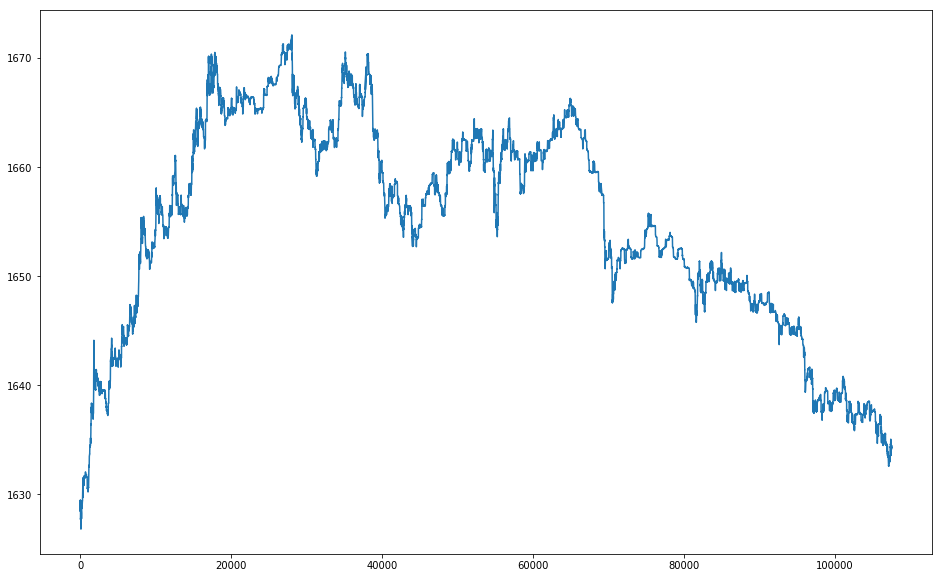

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values);

- plot the maximum price of 2048 ticks
- plot the minimum price of 2048 ticks

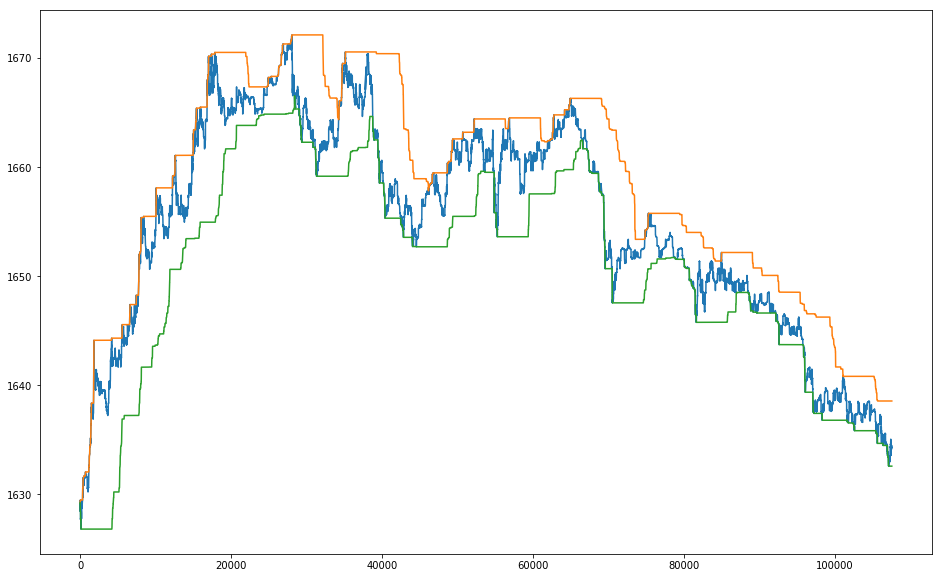

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values)
plt.plot(data["max.4096"].values)
plt.plot(data["min.4096"].values);

## we can see the result meets our expectation
## it may take long time to calculate the min and max of wpr prices
## I give you the estimated time of using 4 cores, so you can deal with other affairs while waiting for result
## but signals using min/max would be sometimes very useful
## the the time to calculating min/max pay off in the end
## In practice, when using c++ to calculating min/max on a rolling basis
## there would be some efficient algorithm, which is faster than comparing all numbers at every tick
## we would talk about it later in our C++ class

- Test 5 predictive signals and generate each result
- now let's see the first signal, which is simply related to price action without trading volume


- set the sample period length

In [16]:
period = 4096

- the first signal

In [19]:
from collections import OrderedDict
class foctor_dbook_period(factor_template):
    factor_name = "dbook.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values

In [20]:
x3 = foctor_dbook_period()
x3
# factor_name:
# dbook.period

# formula:
#     def formula(self, data, period):
#         diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
#         diff_bid_qty[0] = 0
#         diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
#         diff_ask_qty[0] = 0
#         return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values


# params:
# $period:[1024 2048 4096]

factor_name:
dbook.period

formula:
    def formula(self, data, period):
        diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values


params:
$period:[1024 2048 4096]

- create directory for dbook signal

In [22]:
for product in product_list:
    create_signal_path(x3, product, HEAD_PATH)

d:/intern/tmp pkl/rb/dbook.1024
d:/intern/tmp pkl/rb/dbook.2048
d:/intern/tmp pkl/rb/dbook.4096
d:/intern/tmp pkl/hc/dbook.1024
d:/intern/tmp pkl/hc/dbook.2048
d:/intern/tmp pkl/hc/dbook.4096
d:/intern/tmp pkl/i/dbook.1024
d:/intern/tmp pkl/i/dbook.2048
d:/intern/tmp pkl/i/dbook.4096
d:/intern/tmp pkl/j/dbook.1024
d:/intern/tmp pkl/j/dbook.2048
d:/intern/tmp pkl/j/dbook.4096
d:/intern/tmp pkl/jm/dbook.1024
d:/intern/tmp pkl/jm/dbook.2048
d:/intern/tmp pkl/jm/dbook.4096


In [24]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3, product=product, HEAD_PATH=HEAD_PATH)
;

#Wall time: 16min 16s


Wall time: 16min 16s


- now we write the all.signal part into a function

In [9]:
def get_all_signal(file_list, product, signal_name, period):
    n_files = len(file_list)
    to_choose = (np.arange(n_files)+1) % 10 == 0
    all_signal = np.array([])
    for file in file_list[to_choose]:
        S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        signal = S[data["good"]]
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    return all_signal

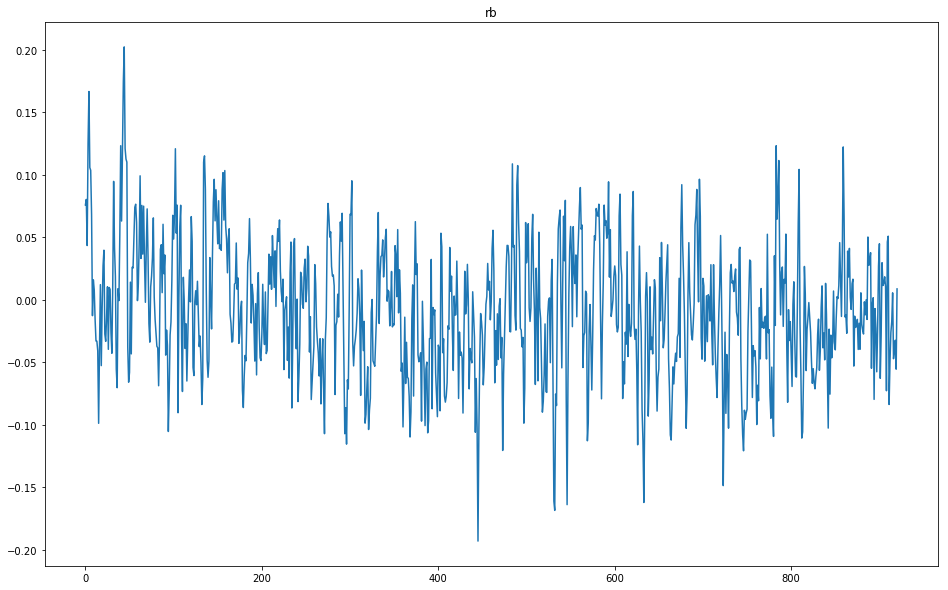

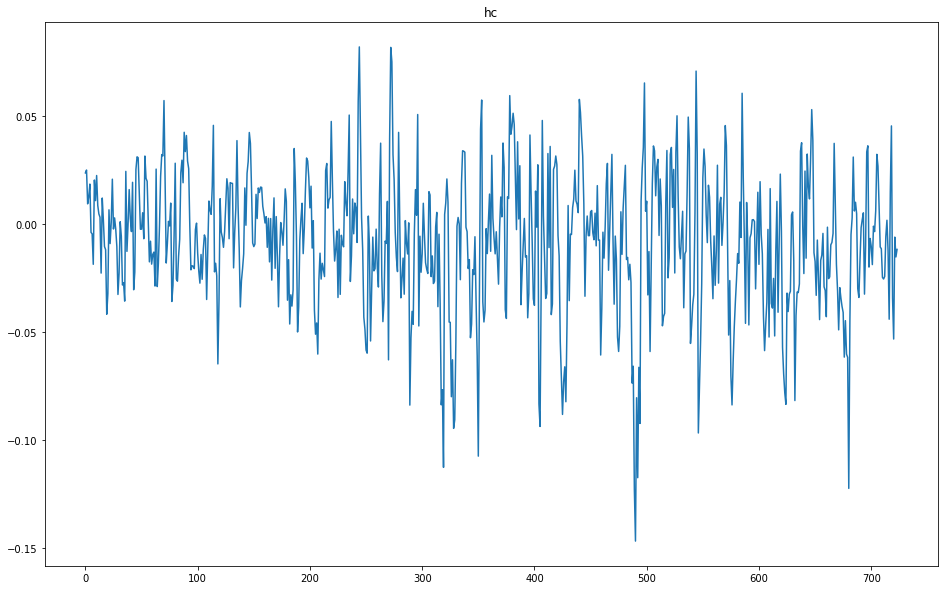

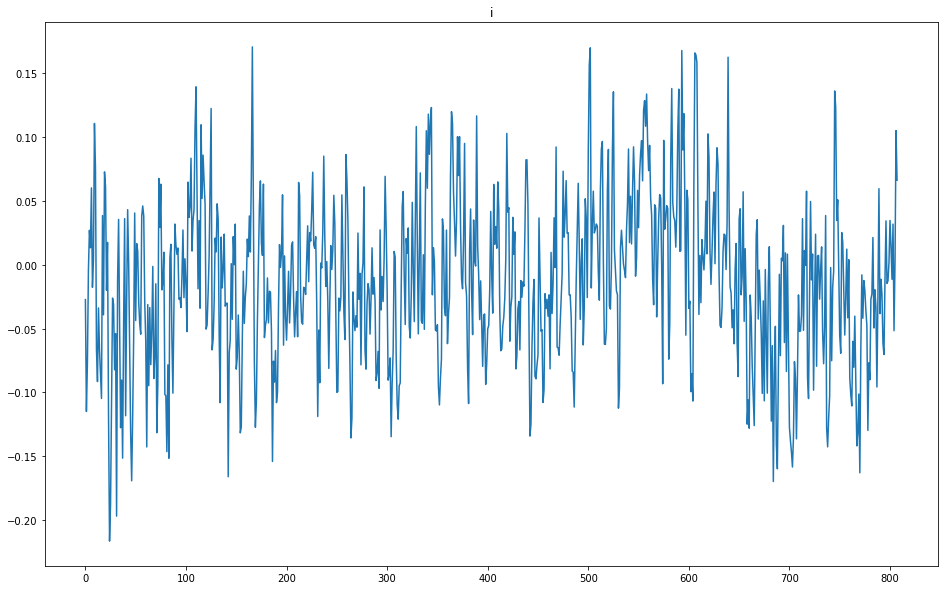

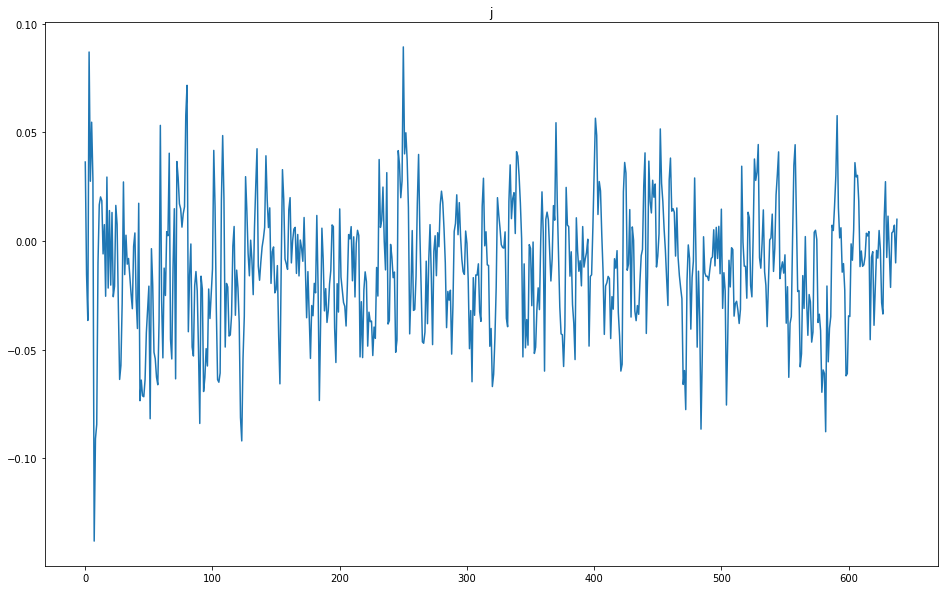

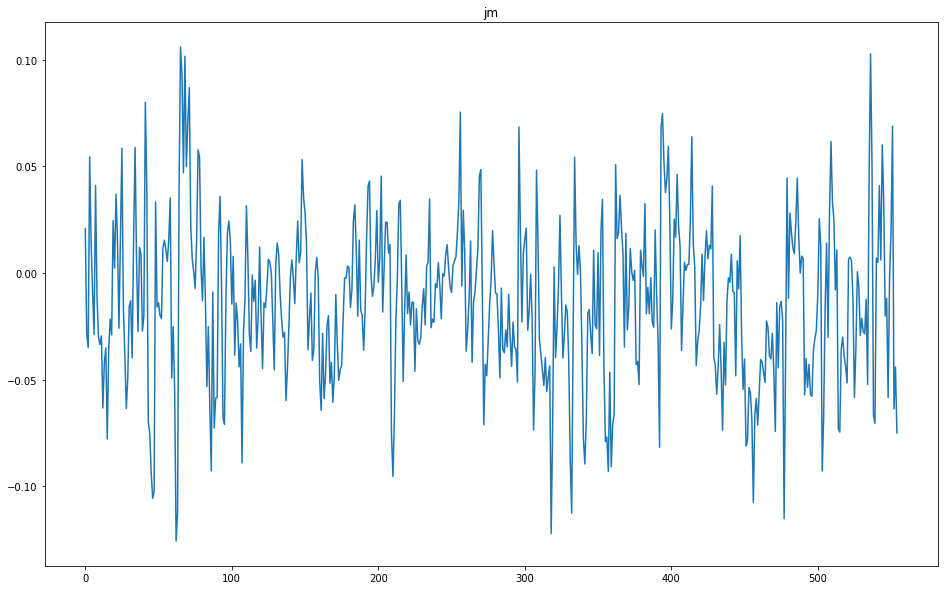

In [31]:
i = 0
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "dbook."+str(period), period)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

In [42]:
print(len(all_signal))
## 385


385
[]


- there is no extreme values

In [10]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.05, 0.15, 0.005)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)

(100, 2)

- get the result of training sample

In [11]:
period = 4096
signal_name = "dbook."+str(period)

In [12]:
train_sample = np.array(all_dates)<"2018"

In [13]:
sum(train_sample)
## 510

510

In [14]:
test_sample = np.array(all_dates)>"2018"
sum(test_sample)
## 405

405

In [20]:
%%time
signal_name = "dbook."+str(period)
all_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=1.1e-4, max_spread=spread+0.1, tranct_ratio=True, atr_filter=20)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

# Wall time: 13min 14s


Wall time: 13min 14s


In [21]:
save(all_trade_stat, HEAD_PATH+"/"+"all_trade_stat_"+signal_name+".pkl")

In [22]:
all_trade_stat = load(HEAD_PATH+"/"+"all_trade_stat_"+signal_name+".pkl")

- get the statistics result of training sample

In [23]:
all_trade_stat = load(HEAD_PATH+"/"+"all_trade_stat_"+signal_name+".pkl")
date_str = [n[0:8] for n in all_dates]

format_dates = np.array([pd.to_datetime(d) for d in date_str])

- let's see how many good signals there are

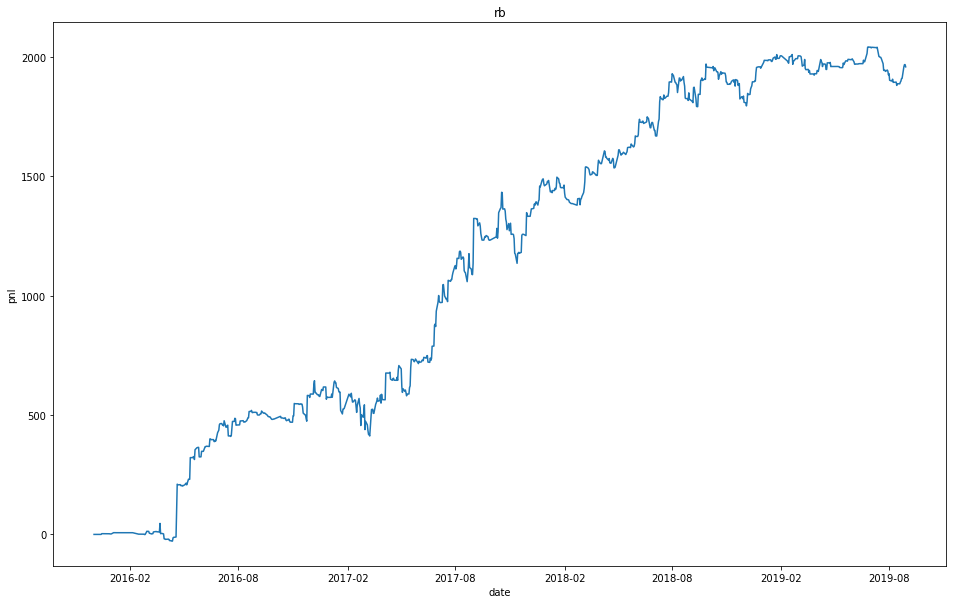

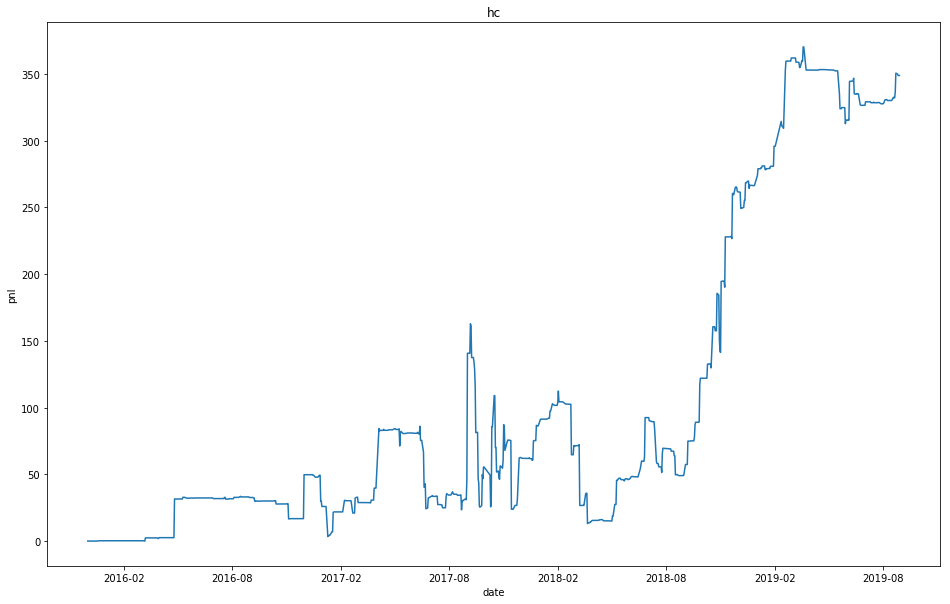

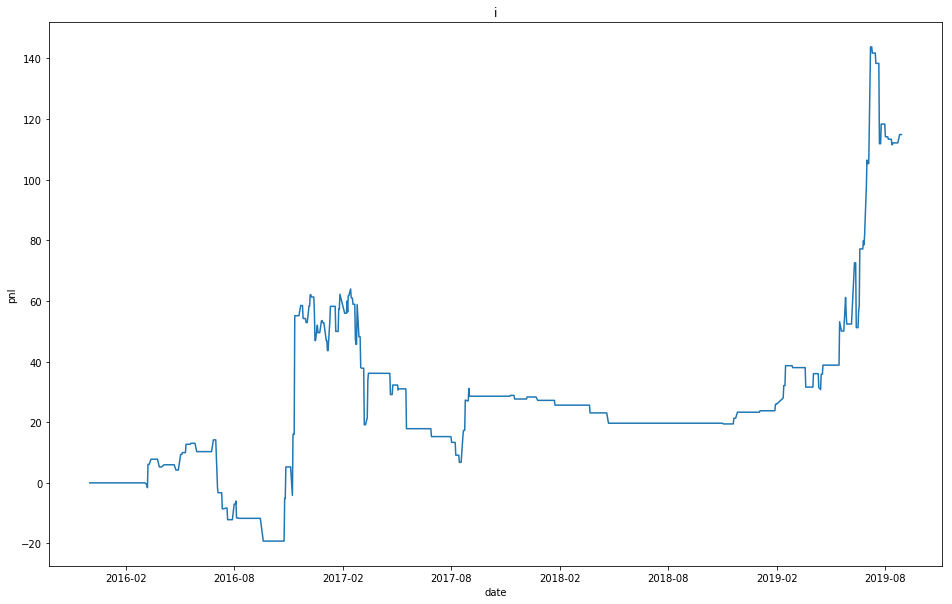

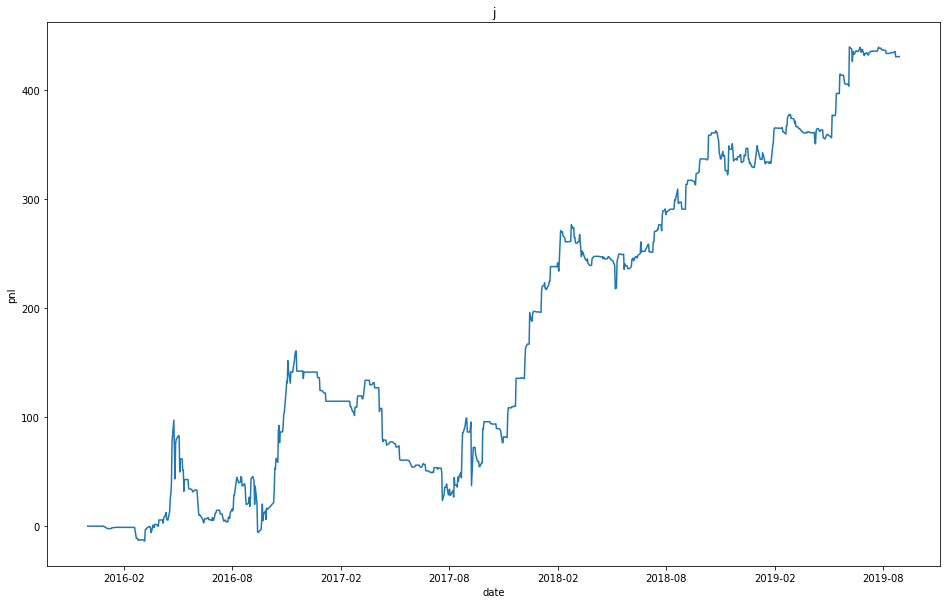

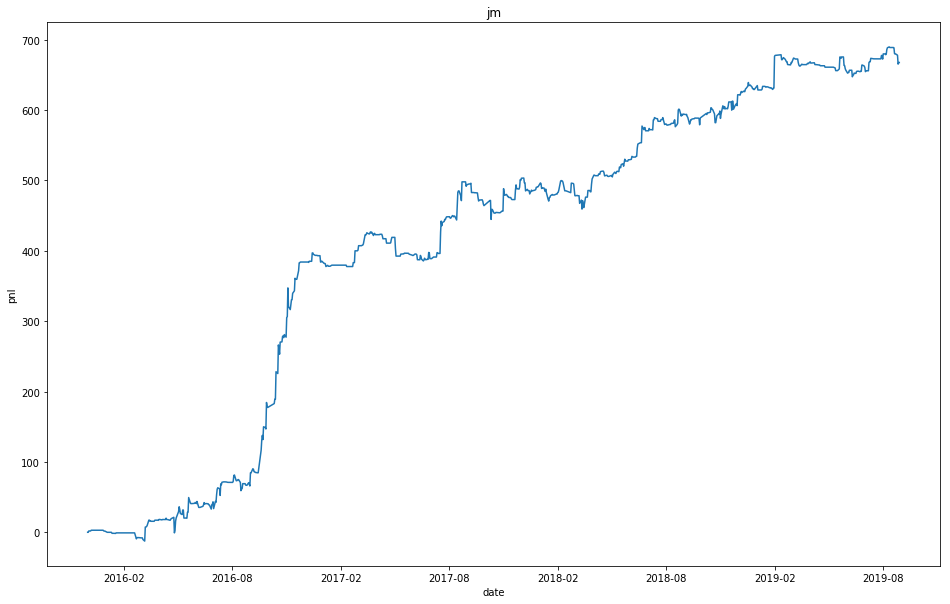

In [24]:
i = 0
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    if sum(good_strat)>2:
        good_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title(product);
        plt.plot(format_dates, good_pnl.cumsum());

- we can see the result is quite good
- now we can split the samples into training and testing sets

In [25]:
%%time
train_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=1.1e-4, max_spread=spread+0.1, tranct_ratio=True, atr_filter=20)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(train_sample))
    train_trade_stat[product] = trade_stat
    
## Wall time: 7min

Wall time: 7min


In [28]:
save(train_trade_stat, HEAD_PATH+"/" + signal_name+"_train_trade_stat.pkl")

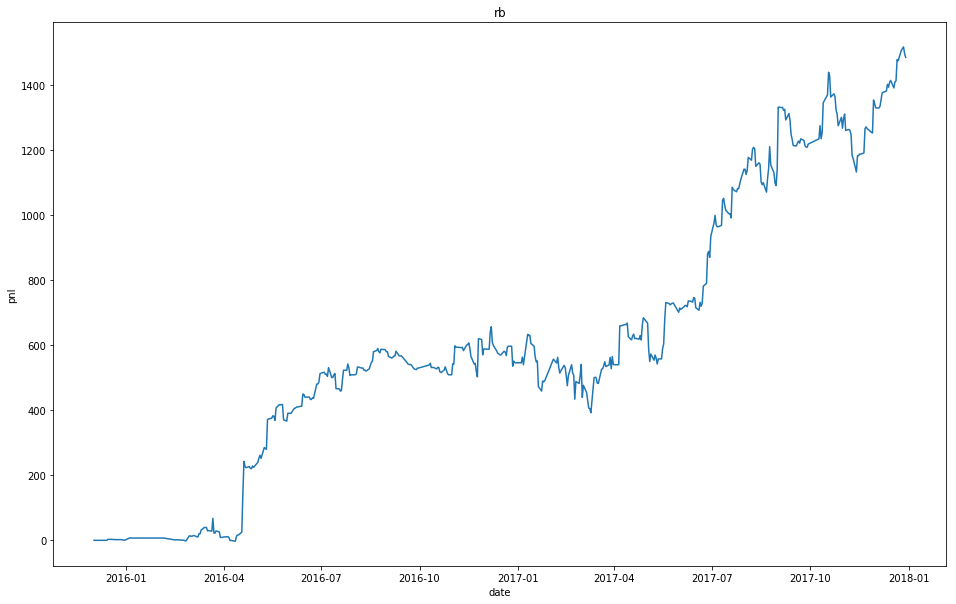

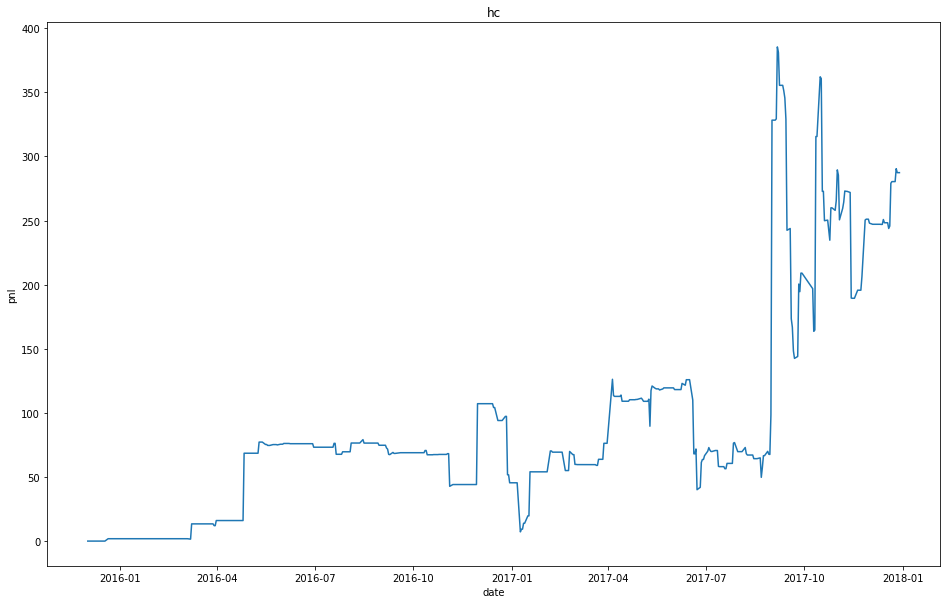

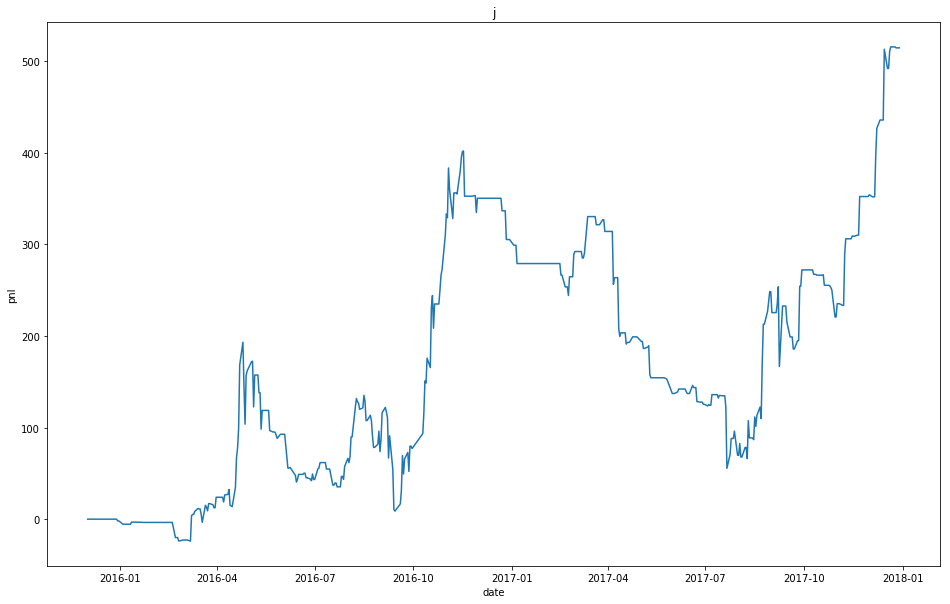

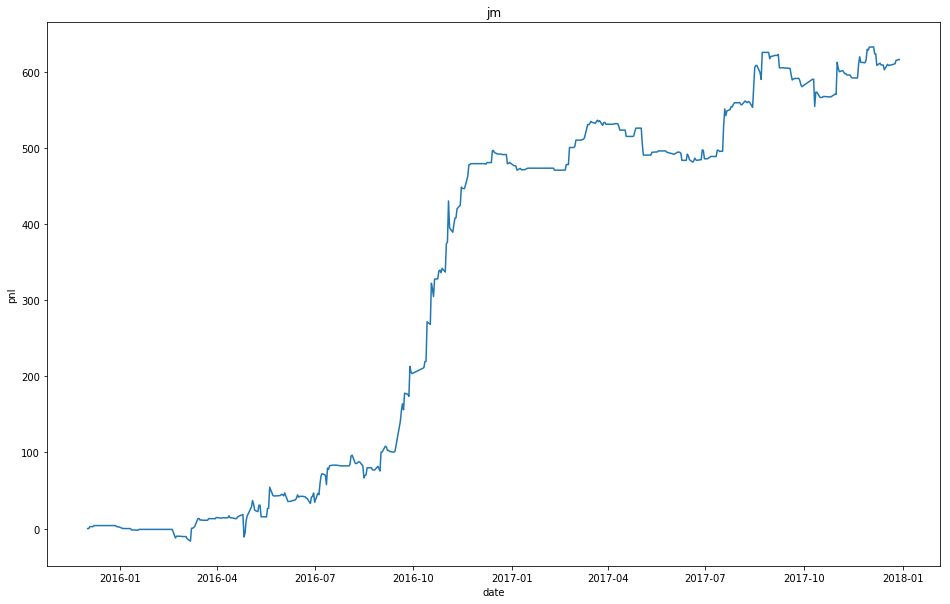

In [32]:
i = 0
train_trade_stat = load(HEAD_PATH+"/" + signal_name +"_train_trade_stat.pkl")
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>2*spread) & (trade_stat["final.result"]["num"]>20)
    if sum(good_strat)>0:
        good_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title(product);
        plt.plot(format_dates[train_sample], good_pnl.cumsum());

In [33]:
%%time
test_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=1.1e-4, max_spread=spread+0.1, tranct_ratio=True, atr_filter=20)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(train_sample))
    test_trade_stat[product] = trade_stat
    
# Wall time: 5min 59s


Wall time: 5min 59s


- at last we plot the selected pnl

- we can check its sharp ratio

In [34]:
save(test_trade_stat, HEAD_PATH+"/" + signal_name + "_test_trade_stat.pkl")

- now let's check how it performs on the test set

rb train sharpe  1.7146052225405781 test sharpe  0.8935486500292946
hc train sharpe  0.5304613262578438 test sharpe  1.6312554468872669
j train sharpe  1.0233829624695328 test sharpe  1.4281183054023177
jm train sharpe  2.26377986678583 test sharpe  1.4641961735846094


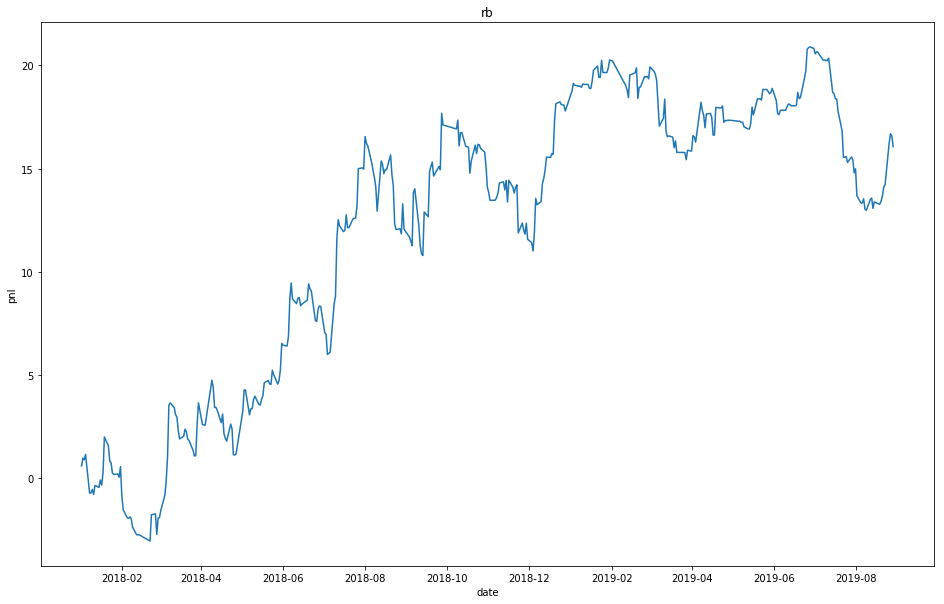

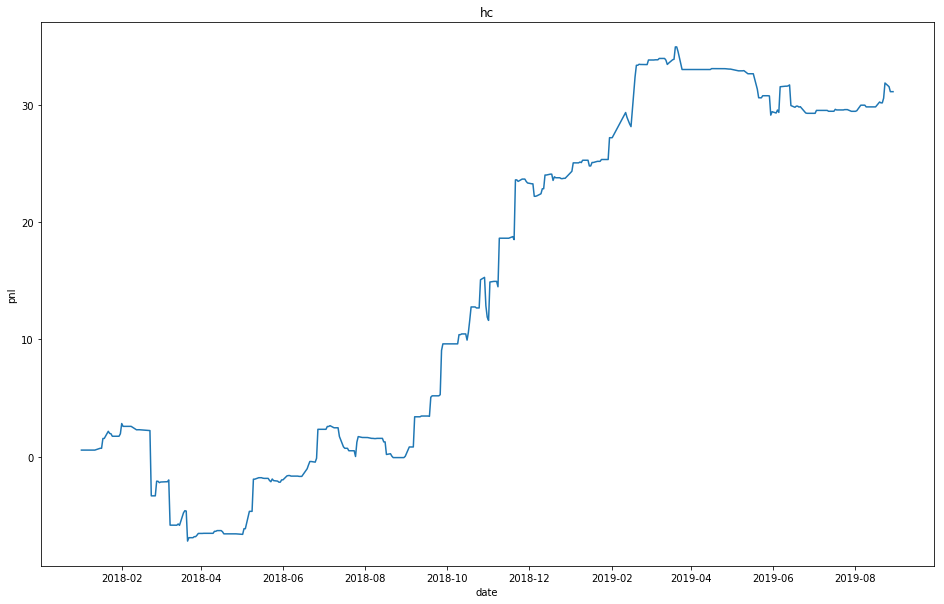

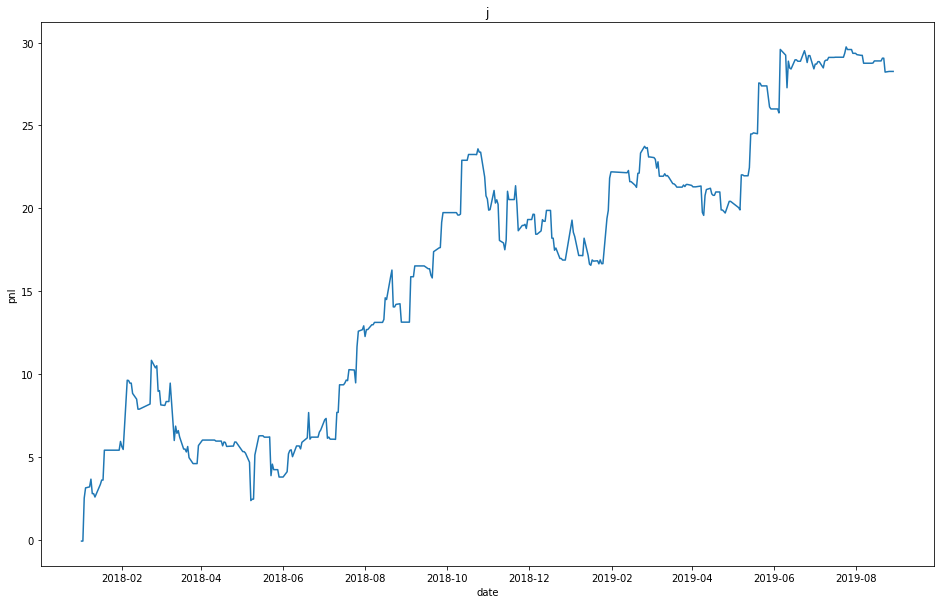

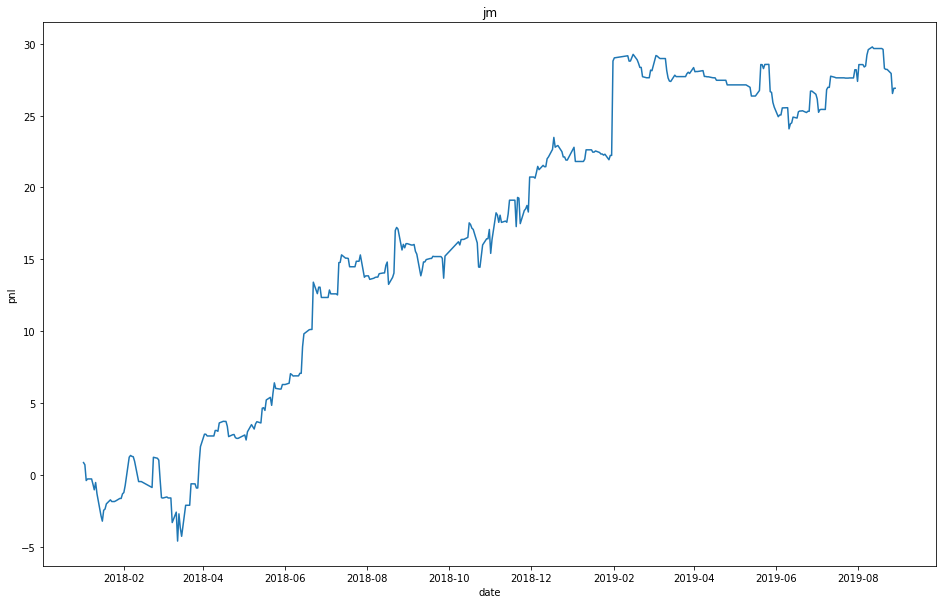

In [35]:
i = 0
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>2*spread) & (trade_stat["final.result"]["num"]>20)
    if sum(good_strat)>0:
        train_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        train_std = np.std(train_pnl)
        train_pnl = train_pnl/train_std
        trade_stat = test_trade_stat[product]
        test_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
        print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
        test_all_pnl[:,i] = test_pnl
        train_all_pnl[:,i] = train_pnl
        i = i+1
        plt.figure(i, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title(product);
        plt.plot(format_dates[test_sample], test_pnl.cumsum());
    
# rb train sharpe  1.7146052225405781 test sharpe  0.8935486500292946
# hc train sharpe  0.5304613262578438 test sharpe  1.6312554468872669
# j train sharpe  1.0233829624695328 test sharpe  1.4281183054023177
# jm train sharpe  2.26377986678583 test sharpe  1.4641961735846094



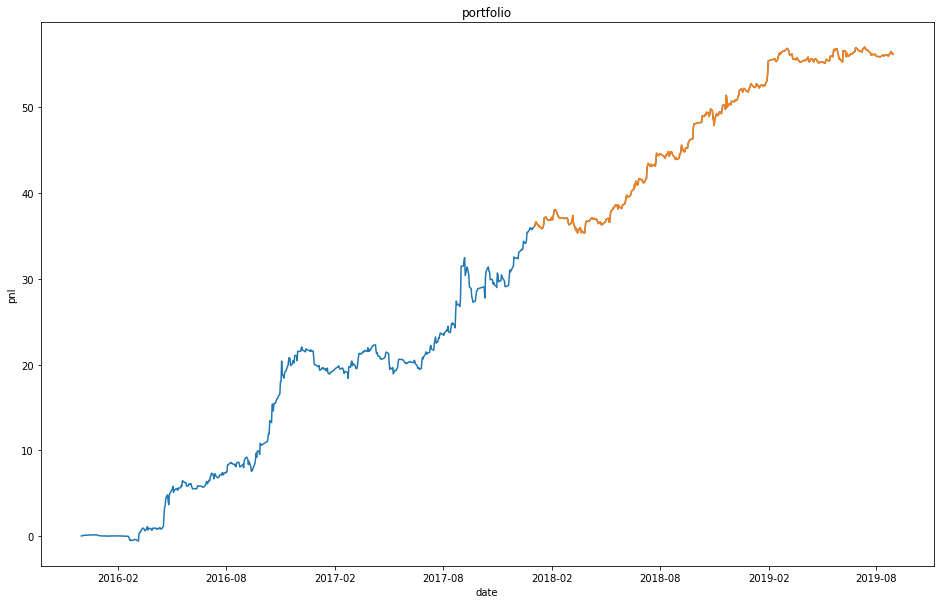

In [36]:
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
all_portfolio
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
    

- now we see the pnl curve

In [37]:
print(sharpe(train_portfolio), sharpe(test_portfolio))
## 2.3608538886787502 2.5299123228849805


2.3608538886787502 2.5299123228849805


summary:

- i performs badly in the training set, so it doesn't have any strategies for the test sets, in which it performs well though;

- signal values differ significantly for every product, it makes parameter optimization quite difficult;

- test sets perform better than training set, but it cannot break new high for a long time recently

possible solution:
- choose strategies not based on performance, we can limit the parameters to a small range, and use risk parity to allocate weights to all of them;
- we can use Bayesian Optimization to choose parameters automatically to avoid humen intervention;
- maybe adding i can make the strategies break new high recently

we can try these solutions in the future

- at last we plot the selected pnl

- now we can combine all of these to a function

In [99]:
from collections import OrderedDict
def get_list_signal_stat(signal_name, thre_mat, product_list, all_dates, split_str="2018", reverse=1, tranct=1.1e-4, 
                    tranct_ratio=True, min_pnl=2, min_num=20, atr_filter=20):
    CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
    train_sample = np.array(all_dates)<split_str
    test_sample = np.array(all_dates)>split_str
    date_str = [n[0:8] for n in all_dates]
    format_dates = np.array([pd.to_datetime(d) for d in date_str])
    train_trade_stat = dict([])
    print("training")
    for product in product_list:
        spread = product_info[product]["spread"]
        with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
            f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=reverse, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=atr_filter)
            train_result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
        trade_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
        train_trade_stat[product] = trade_stat
    print("testing")
    test_trade_stat = dict([])
    for product in product_list:
        spread = product_info[product]["spread"]
        with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
            f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                     reverse=reverse, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=atr_filter)
            result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
        trade_stat = get_hft_summary(result, thre_mat, sum(train_sample))
        test_trade_stat[product] = trade_stat
    result=dict([])
    result["train_trade_stat"] = train_trade_stat
    result["test_trade_stat"] = test_trade_stat
    if reverse==-1:
        save(result, HEAD_PATH+"/"+signal_name+".result.pkl")
    else:
        save(result, HEAD_PATH+"/"+signal_name+".pos.result.pkl")

In [100]:
def get_list_signal_result(signal_name, product_list, all_dates, split_str="2018", reverse=1, tranct=1.1e-4, 
                    tranct_ratio=True, min_pnl=2, min_num=20, atr_filter=20):
    if reverse==-1:
        result = load(HEAD_PATH+"/"+signal_name+".result.pkl")
    else:
        result = load(HEAD_PATH+"/"+signal_name+".pos.result.pkl")
    train_trade_stat = result["train_trade_stat"]
    test_trade_stat = result["test_trade_stat"]
    train_sample = np.array(all_dates)<split_str
    test_sample = np.array(all_dates)>split_str
    date_str = [n[0:8] for n in all_dates]
    format_dates = np.array([pd.to_datetime(d) for d in date_str])
    i = 0
    test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
    train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
    for product in product_list:
        spread = product_info[product]["spread"]
        trade_stat = train_trade_stat[product]
        good_strat = (trade_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (trade_stat["final.result"]["num"]>min_num)
        if sum(good_strat)>0:
            train_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
            train_std = np.std(train_pnl)
            train_pnl = train_pnl/train_std
            trade_stat = test_trade_stat[product]
            test_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
            print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
            test_all_pnl[:,i] = test_pnl
            train_all_pnl[:,i] = train_pnl
            i = i+1
    train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
    test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
    all_portfolio = np.append(train_portfolio, test_portfolio)
    plt.figure(1, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title("portfolio");
    plt.plot(format_dates, all_portfolio.cumsum());
    plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
    signal_stat = dict([])
    signal_stat["train.stat"] = train_trade_stat
    signal_stat["test.stat"] = test_trade_stat
    print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))


rb train sharpe  1.7146052225405781 test sharpe  0.8935486500292946
hc train sharpe  0.5304613262578438 test sharpe  1.6312554468872669
j train sharpe  1.0233829624695328 test sharpe  1.4281183054023177
jm train sharpe  2.26377986678583 test sharpe  1.4641961735846094
train sharpe:  2.3608538886787502 test sharpe:  2.5299123228849805


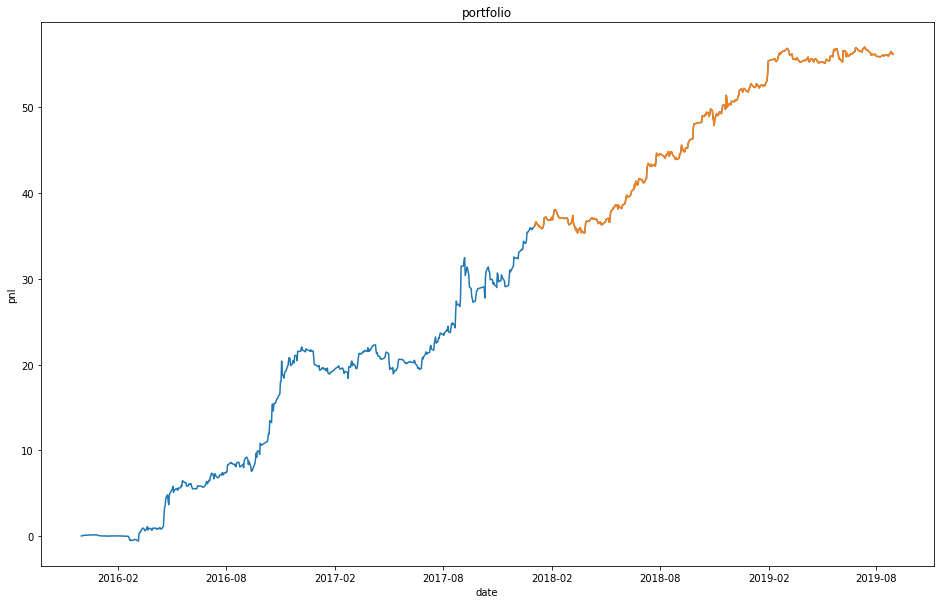

In [45]:
get_list_signal_stat("dbook.4096", thre_mat, product_list, all_dates, split_str="2018", reverse=-1, tranct=1.1e-4, 
                    tranct_ratio=True, min_pnl=2, min_num=20, atr_filter=20)

get_list_signal_result("dbook.4096", product_list, all_dates, split_str="2018", reverse=-1, tranct=1.1e-4, 
                    tranct_ratio=True, min_pnl=2, min_num=20, atr_filter=20)

# testing
# rb train sharpe  1.7146052225405781 test sharpe  0.8935486500292946
# hc train sharpe  0.5304613262578438 test sharpe  1.6312554468872669
# j train sharpe  1.0233829624695328 test sharpe  1.4281183054023177
# jm train sharpe  2.26377986678583 test sharpe  1.4641961735846094
# train sharpe:  2.3608538886787502 test sharpe:  2.5299123228849805


In [87]:
signal_stat.keys()
## odict_keys(['train.stat', 'test.stat', 'good.strat'])

odict_keys(['train.stat', 'test.stat', 'good.strat'])

- we can test other signals

In [50]:
from collections import OrderedDict
class foctor_range_pos_period(factor_template):
    factor_name = "range.pos.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return get_range_pos(data["wpr"], data["min."+str(period)], data["max."+str(period)], period).values

- let's see waht it looks like

In [51]:
x4_1 = foctor_range_pos_period()
## we've changed it a little bit from week 2 by adding
## xs.new <- gsub(para.name, value, xs)    
## aa <- with(data,eval(parse(text=xs.new)))
## so be aware that the name of parameter should be complex enough to avoid error

- now we can create path

In [52]:
for product in product_list:
    create_signal_path(x4_1, product, HEAD_PATH)

d:/intern/tmp pkl/rb/range.pos.1024
d:/intern/tmp pkl/rb/range.pos.2048
d:/intern/tmp pkl/rb/range.pos.4096
d:/intern/tmp pkl/hc/range.pos.1024
d:/intern/tmp pkl/hc/range.pos.2048
d:/intern/tmp pkl/hc/range.pos.4096
d:/intern/tmp pkl/i/range.pos.1024
d:/intern/tmp pkl/i/range.pos.2048
d:/intern/tmp pkl/i/range.pos.4096
d:/intern/tmp pkl/j/range.pos.1024
d:/intern/tmp pkl/j/range.pos.2048
d:/intern/tmp pkl/j/range.pos.4096
d:/intern/tmp pkl/jm/range.pos.1024
d:/intern/tmp pkl/jm/range.pos.2048
d:/intern/tmp pkl/jm/range.pos.4096


- then we calculate the signal

In [53]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x4_1, product=product, HEAD_PATH=HEAD_PATH)
;

#Wall time: 5min 13s


Wall time: 5min 13s


- then we can see how the signal looks like

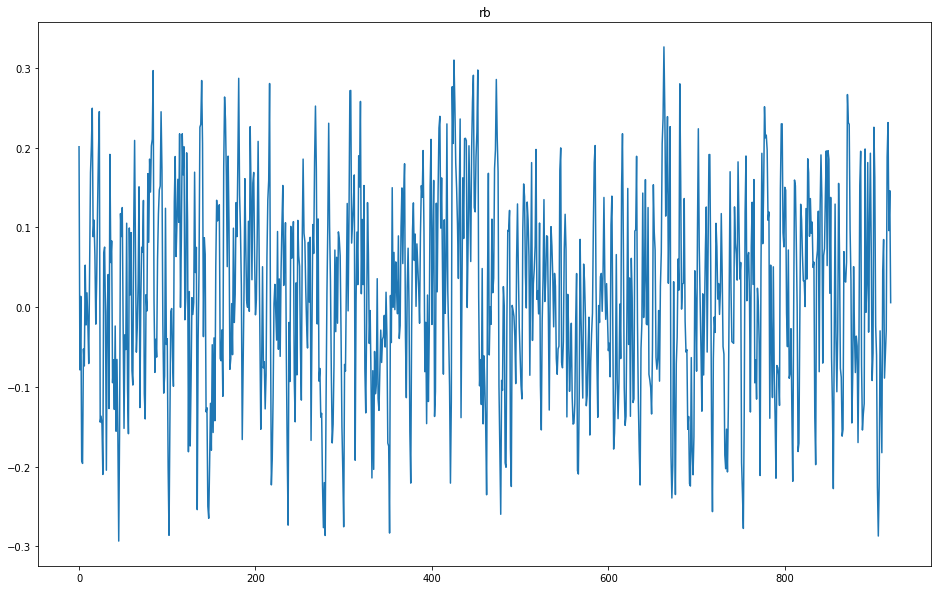

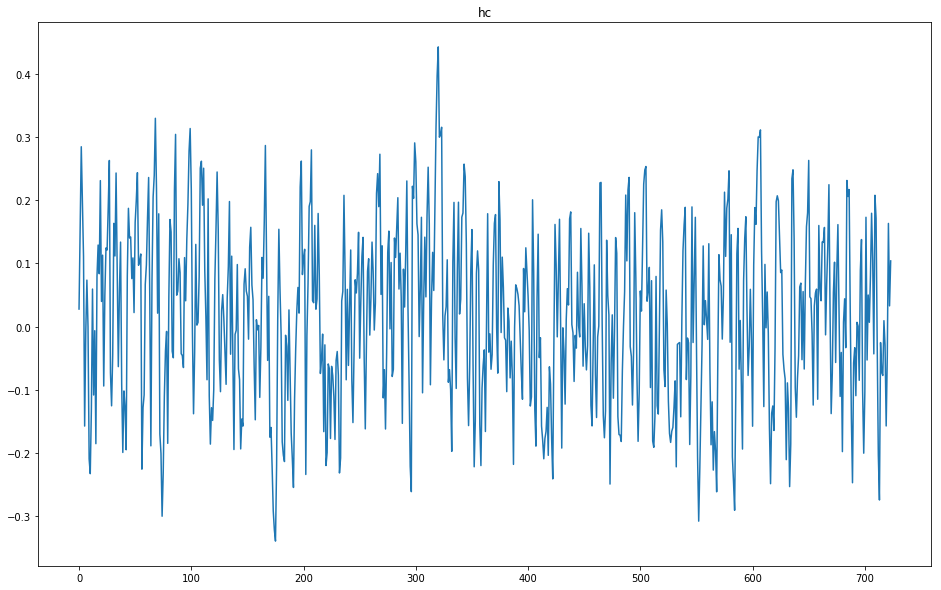

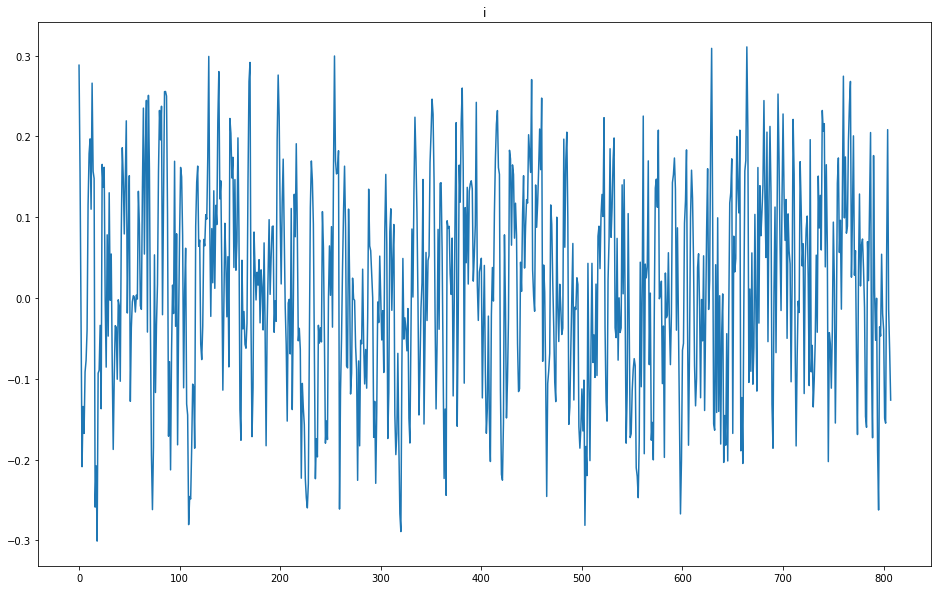

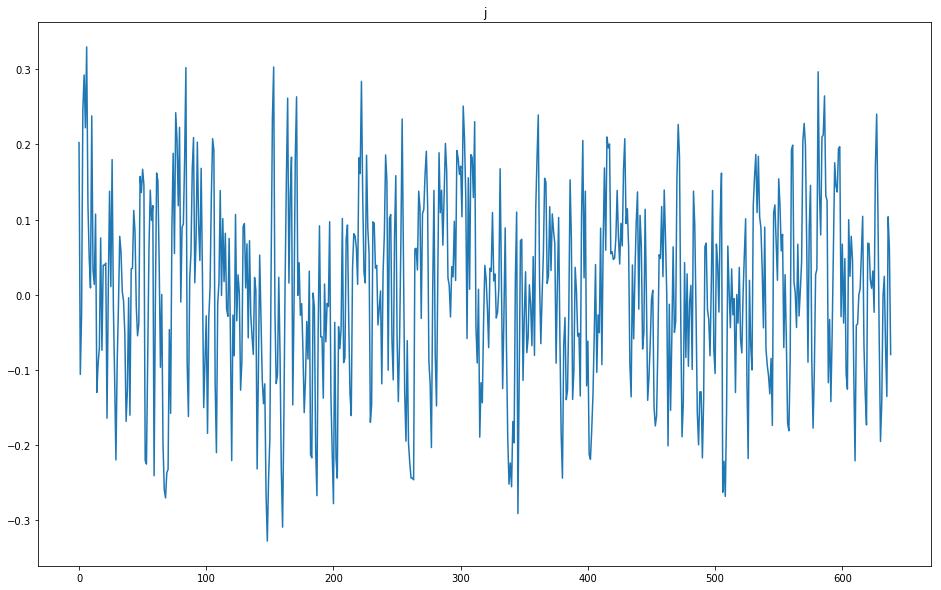

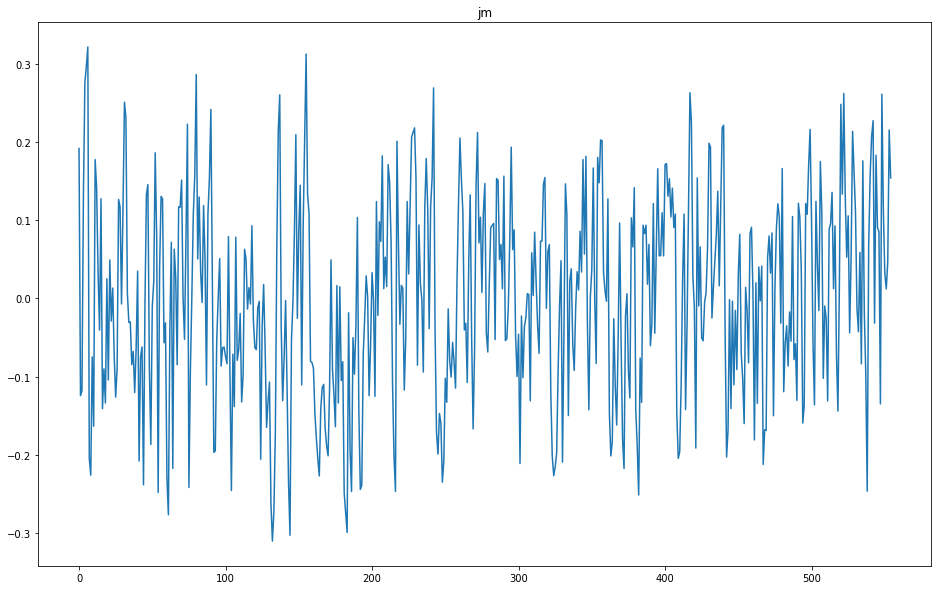

In [55]:
i = 0
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "range.pos."+str(period), period)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

- there is no extreme values

In [19]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.1, 0.3, 0.01)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)

(100, 2)

training
testing
rb train sharpe  0.3391384707484542 test sharpe  -0.6925920899361676
hc train sharpe  0.5676248411669498 test sharpe  0.48956248241732714
j train sharpe  0.389335594837464 test sharpe  -0.24245972047156247
jm train sharpe  0.6969061978602192 test sharpe  0.7808918712244813
train sharpe:  0.7359477008715128 test sharpe:  -0.09651449138442883
Wall time: 21min 53s


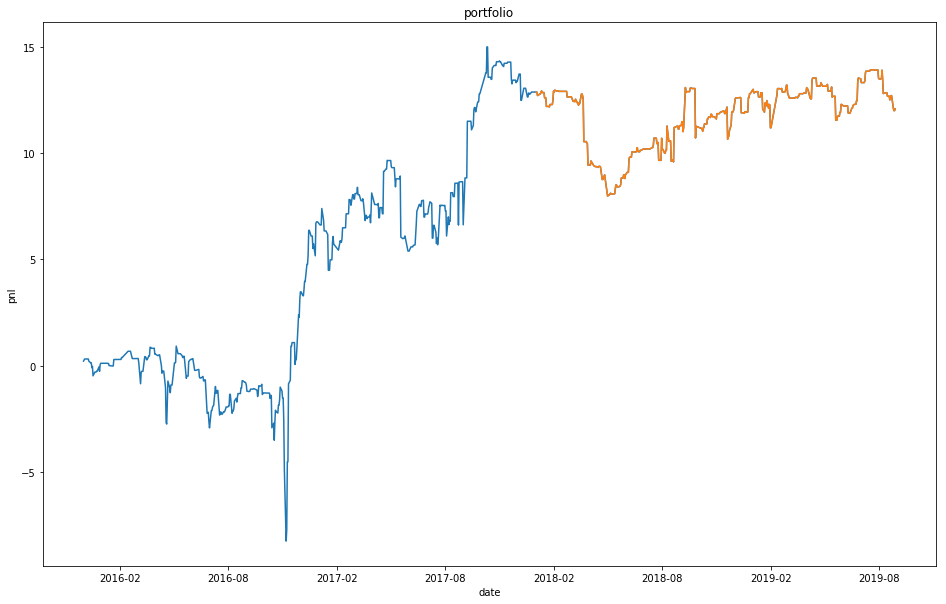

In [20]:
%%time
signal_stat = get_list_signal_stat("range.pos.4096", thre_mat, product_list, all_dates, reverse=-1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=2, min_num=20)

# training
# testing
# rb train sharpe  0.3391384707484542 test sharpe  -0.6925920899361676
# hc train sharpe  0.5676248411669498 test sharpe  0.48956248241732714
# j train sharpe  0.389335594837464 test sharpe  -0.24245972047156247
# jm train sharpe  0.6969061978602192 test sharpe  0.7808918712244813
# train sharpe:  0.7359477008715128 test sharpe:  -0.09651449138442883
## Wall time: 21min 53s



rb train sharpe  0.25975247229700077 test sharpe  -0.588059479597231
hc train sharpe  0.47865017821124906 test sharpe  0.542401034179561
i train sharpe  0.49301201372683 test sharpe  0.2111186919787159
j train sharpe  0.389335594837464 test sharpe  -0.24245972047156247
jm train sharpe  0.5639431845783904 test sharpe  0.8348013798296944
train sharpe:  0.7418042924880256 test sharpe:  0.10397864568926324


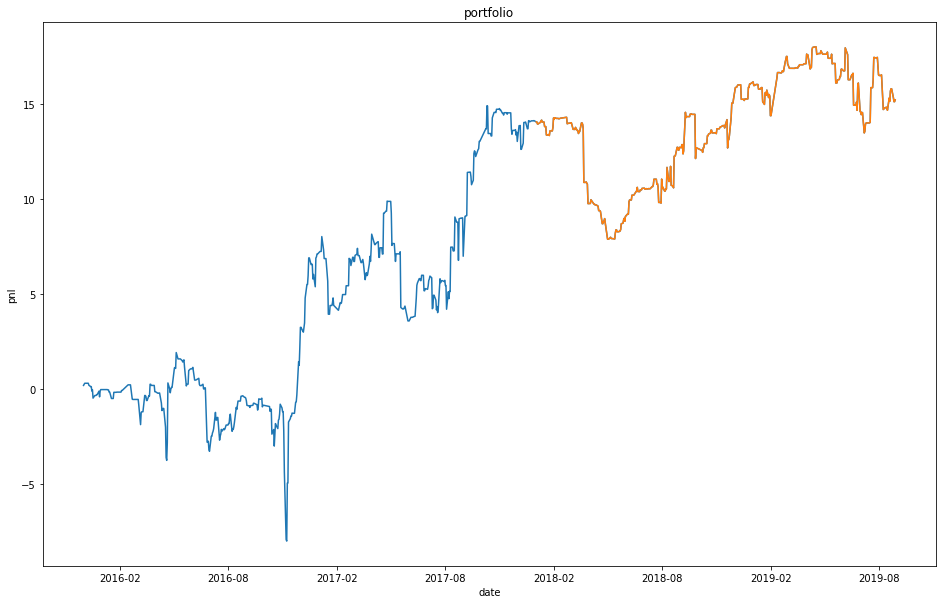

In [48]:
signal_stat = get_list_signal_result("range.pos.4096", product_list, all_dates, reverse=-1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=1, min_num=10)

In [55]:
from collections import OrderedDict
class foctor_nr_period(factor_template):
    factor_name = "nr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["ret"], period, adjust=True), ewma(data["ret"].abs(), period, adjust=True)).values

In [56]:
x5 = foctor_nr_period()
for product in product_list:
    create_signal_path(x5, product, HEAD_PATH)

d:/intern/tmp pkl/rb/nr.1024
d:/intern/tmp pkl/rb/nr.2048
d:/intern/tmp pkl/rb/nr.4096
d:/intern/tmp pkl/hc/nr.1024
d:/intern/tmp pkl/hc/nr.2048
d:/intern/tmp pkl/hc/nr.4096
d:/intern/tmp pkl/i/nr.1024
d:/intern/tmp pkl/i/nr.2048
d:/intern/tmp pkl/i/nr.4096
d:/intern/tmp pkl/j/nr.1024
d:/intern/tmp pkl/j/nr.2048
d:/intern/tmp pkl/j/nr.4096
d:/intern/tmp pkl/jm/nr.1024
d:/intern/tmp pkl/jm/nr.2048
d:/intern/tmp pkl/jm/nr.4096


In [57]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x5, product=product, HEAD_PATH=HEAD_PATH)
;

# Wall time: 5min 2s



Wall time: 5min 2s


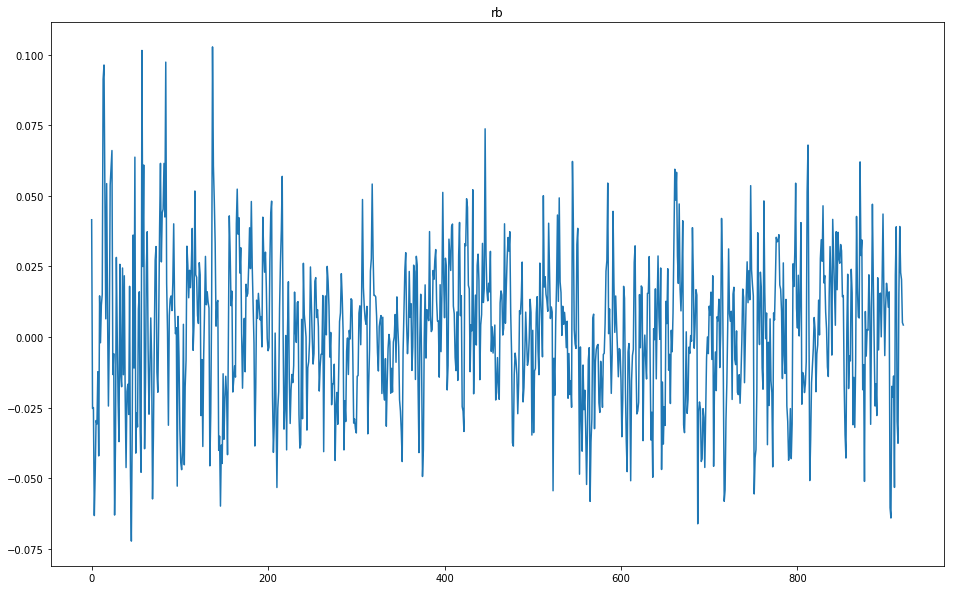

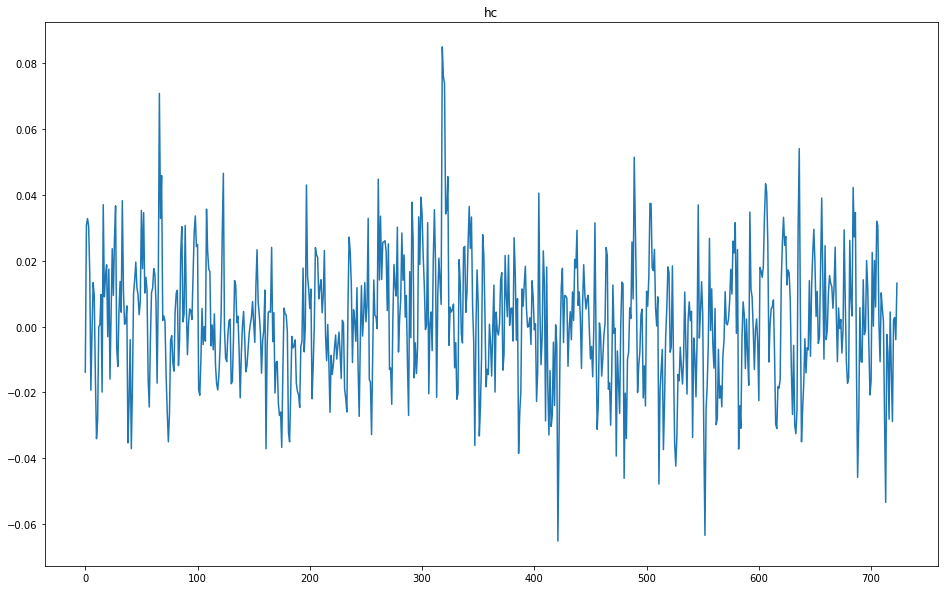

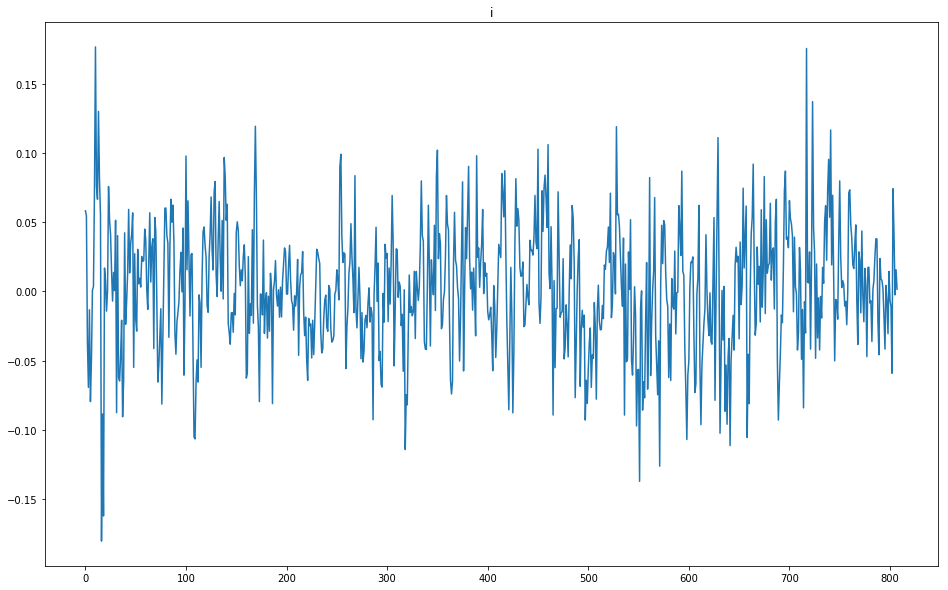

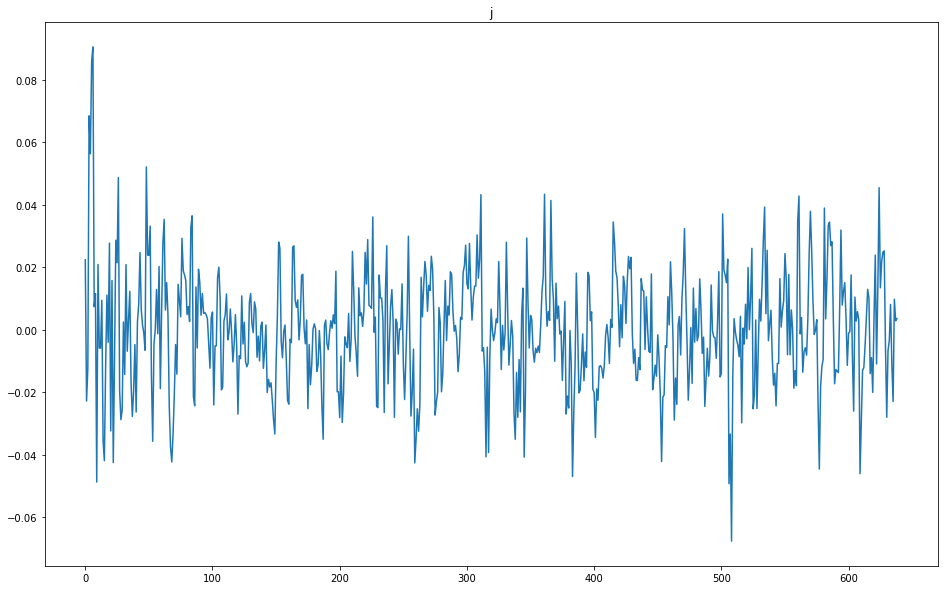

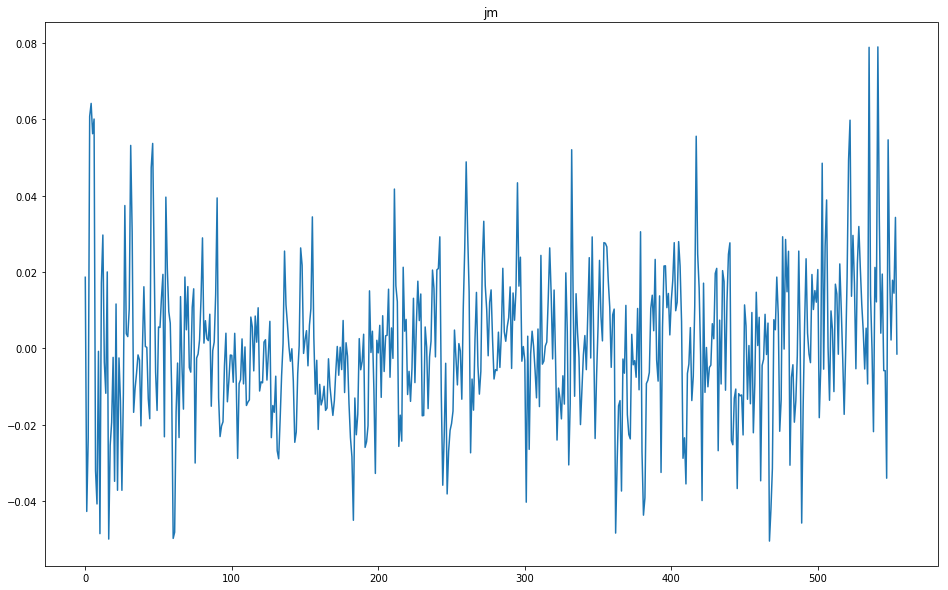

In [59]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "nr."+str(period), period)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

In [60]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.02, 0.08, 0.003)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)

(100, 2)

In [ ]:
%%time
get_signal_moment("nr", all_dates, product_list, 4096)
# rb kurtosis= 3.4083092266976815  skew= 0.1642333600413905
# hc kurtosis= 3.91523474216243  skew= 0.19163584426556832
# i kurtosis= 3.7631836090459285  skew= -0.04916067441085127
# j kurtosis= 4.72195740585039  skew= 0.3154164469614875
# jm kurtosis= 4.178658277271627  skew= 0.40211610590272595

training
testing
hc train sharpe  0.4192432305192631 test sharpe  0.13556197501680867
j train sharpe  0.4071368325464721 test sharpe  -0.17369760286650343
train sharpe:  0.5438426077286185 test sharpe:  -0.07579309998639791


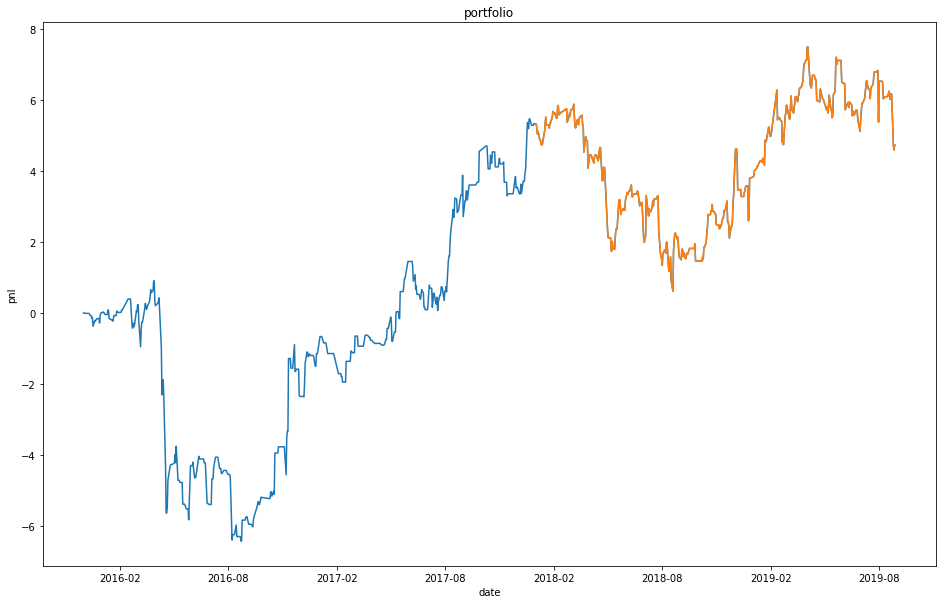

In [61]:
signal_stat = get_list_signal_stat("nr.4096", thre_mat, product_list, all_dates, reverse=-1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=2, min_num=20)
# training
# testing
# hc train sharpe  0.4192432305192631 test sharpe  0.13556197501680867
# j train sharpe  0.4071368325464721 test sharpe  -0.17369760286650343
# train sharpe:  0.5438426077286185 test sharpe:  -0.07579309998639791



hc train sharpe  0.3196303215920011 test sharpe  0.06416048056298457
j train sharpe  0.334661514363695 test sharpe  -0.207259897094479
jm train sharpe  0.23076615750997737 test sharpe  1.660824528047058
train sharpe:  0.444647096831941 test sharpe:  0.8897237454950518


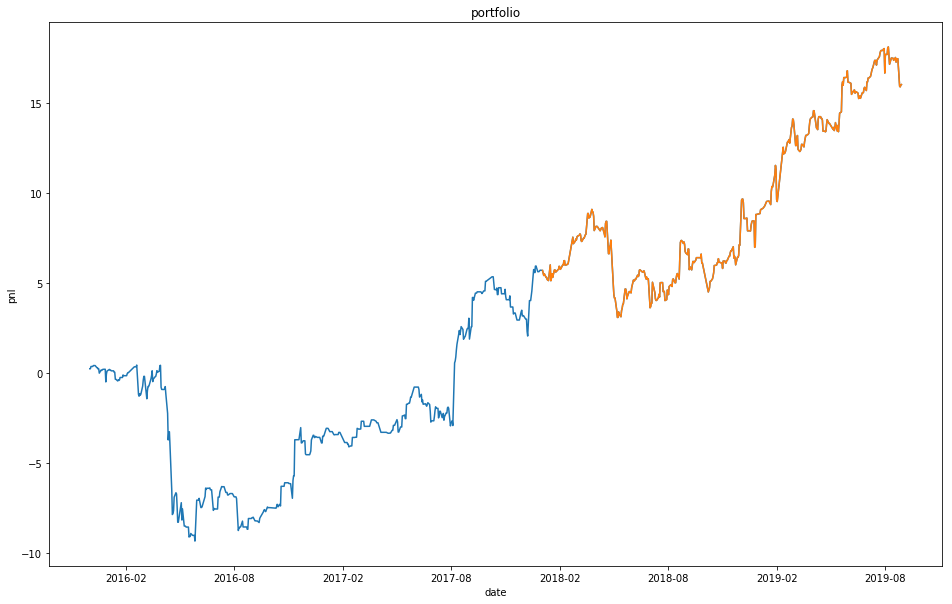

In [65]:
signal_stat = get_list_signal_result("nr.4096", product_list, all_dates, reverse=-1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=1, min_num=20)

In [25]:
from collections import OrderedDict
class foctor_ma_diff_period(factor_template):
    factor_name = "ma.dif.10.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/10), adjust=True) - ewma(data["wpr"], period, adjust=True), data["wpr"]).values

In [26]:
x99_1 = foctor_ma_diff_period()

In [29]:
for product in product_list:
    create_signal_path(x99_1, product, HEAD_PATH)

d:/intern/tmp pkl/rb/ma.dif.10.1024
d:/intern/tmp pkl/rb/ma.dif.10.2048
d:/intern/tmp pkl/rb/ma.dif.10.4096
d:/intern/tmp pkl/hc/ma.dif.10.1024
d:/intern/tmp pkl/hc/ma.dif.10.2048
d:/intern/tmp pkl/hc/ma.dif.10.4096
d:/intern/tmp pkl/i/ma.dif.10.1024
d:/intern/tmp pkl/i/ma.dif.10.2048
d:/intern/tmp pkl/i/ma.dif.10.4096
d:/intern/tmp pkl/j/ma.dif.10.1024
d:/intern/tmp pkl/j/ma.dif.10.2048
d:/intern/tmp pkl/j/ma.dif.10.4096
d:/intern/tmp pkl/jm/ma.dif.10.1024
d:/intern/tmp pkl/jm/ma.dif.10.2048
d:/intern/tmp pkl/jm/ma.dif.10.4096


In [28]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x99_1, product=product, HEAD_PATH=HEAD_PATH)
;
# Wall time: 5min 59s


Wall time: 5min 59s


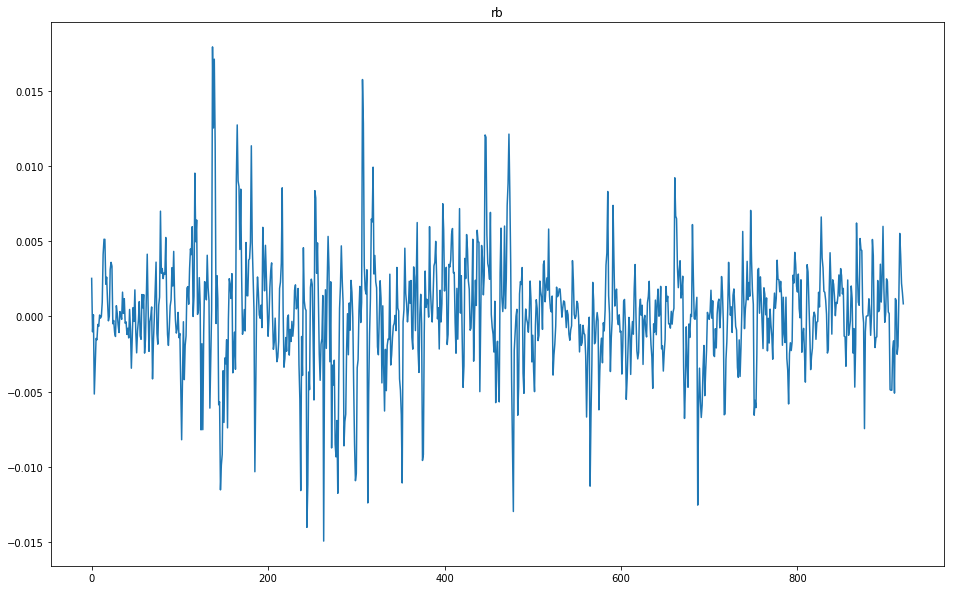

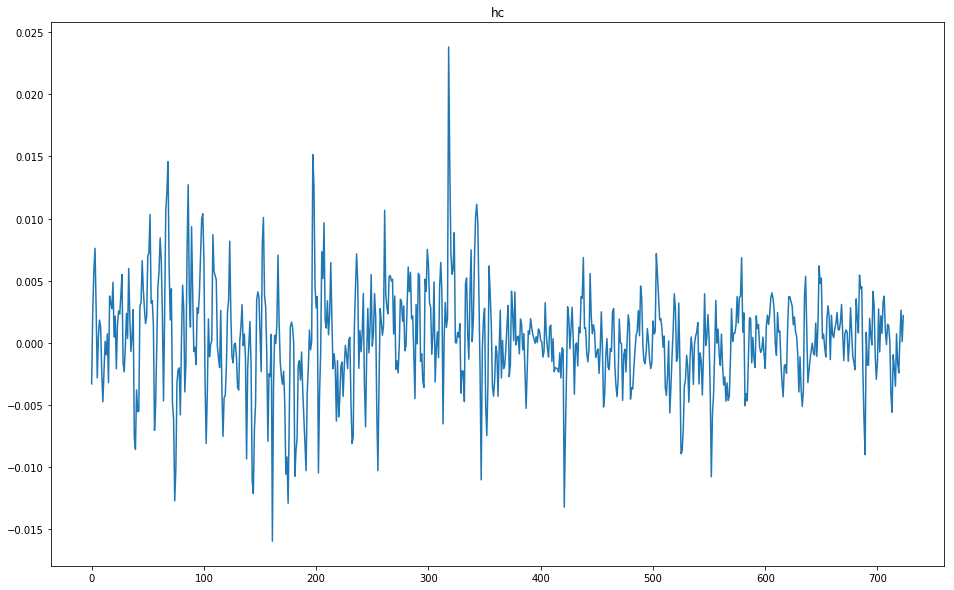

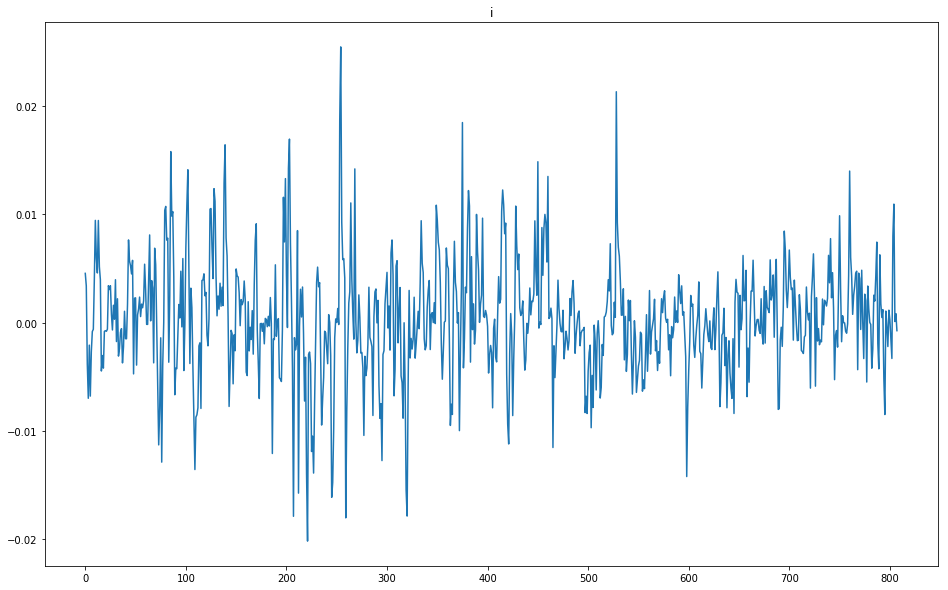

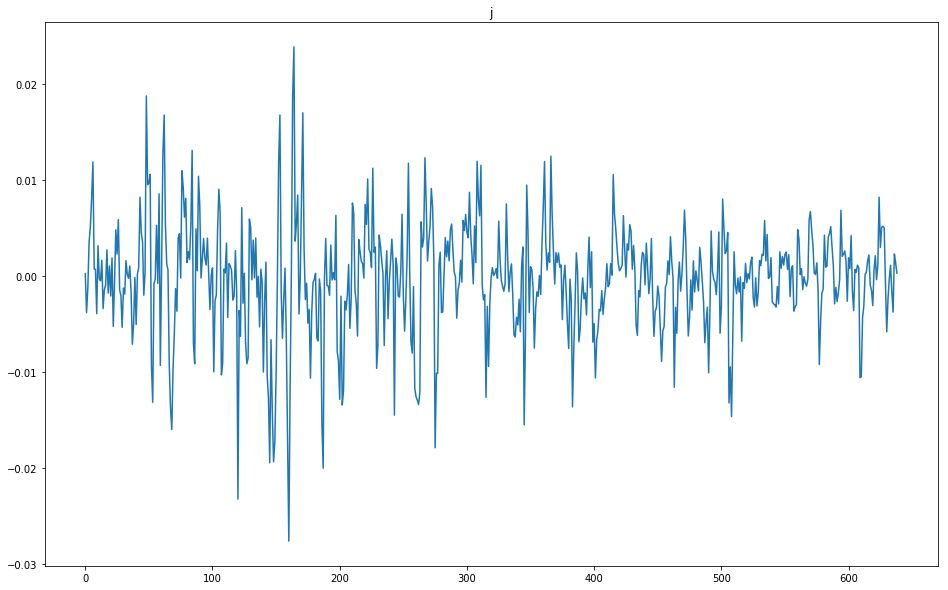

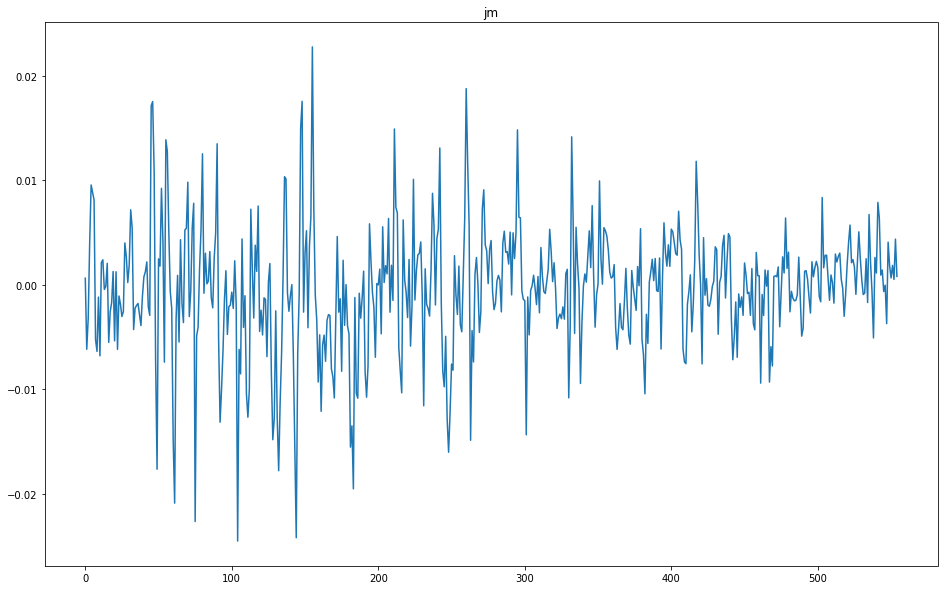

In [88]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "ma.dif.10."+str(period), period)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

In [66]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.005, 0.015, 0.0005)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)

(100, 2)

training
testing
hc train sharpe  0.4103783537922885 test sharpe  0.03988860163254597
train sharpe:  0.41037835379229015 test sharpe:  0.039888601632545956


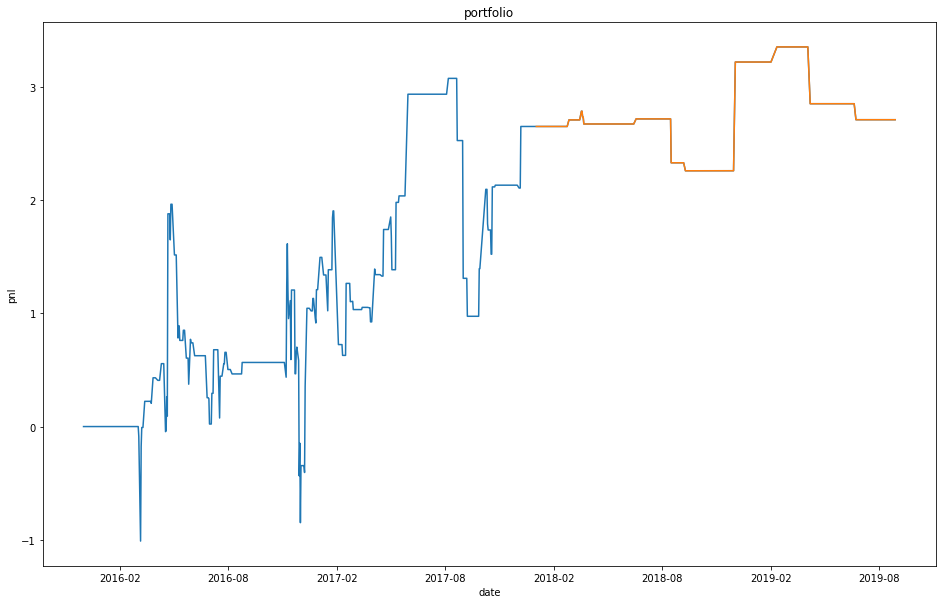

In [67]:
signal_stat = get_list_signal_stat("ma.dif.10.4096", thre_mat, product_list, all_dates, reverse=-1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=2, min_num=20)

hc train sharpe  0.3584831391540025 test sharpe  0.016192917965574576
j train sharpe  0.20799740015460338 test sharpe  0.04787985554523141
jm train sharpe  0.362754325048647 test sharpe  1.2146500981480803
train sharpe:  0.4368839516840886 test sharpe:  0.44202025523888117


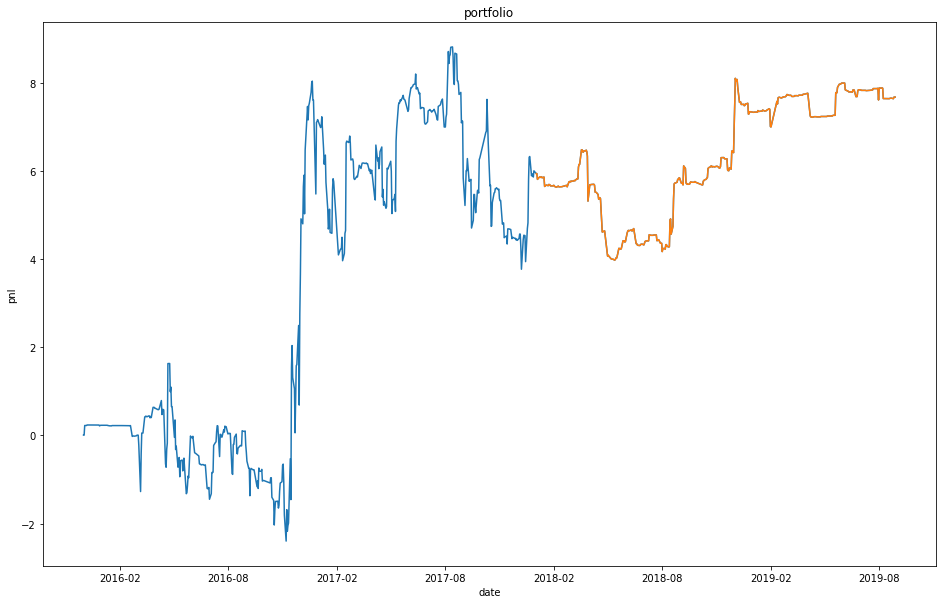

In [72]:
signal_stat = get_list_signal_result("ma.dif.10.4096", product_list, all_dates, reverse=-1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=1, min_num=20)

In [8]:
from collections import OrderedDict
class foctor_price_osci_period(factor_template):
    factor_name = "price.osci.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/20), adjust=True)-ewma(data["wpr"], period, adjust=True), data["max."+str(period)]-data["min."+str(period)]).values

In [9]:
x113 = foctor_price_osci_period()
for product in product_list:
    create_signal_path(x113, product, HEAD_PATH)

d:/intern/tmp pkl/rb/price.osci.1024
d:/intern/tmp pkl/rb/price.osci.2048
d:/intern/tmp pkl/rb/price.osci.4096
d:/intern/tmp pkl/hc/price.osci.1024
d:/intern/tmp pkl/hc/price.osci.2048
d:/intern/tmp pkl/hc/price.osci.4096
d:/intern/tmp pkl/i/price.osci.1024
d:/intern/tmp pkl/i/price.osci.2048
d:/intern/tmp pkl/i/price.osci.4096
d:/intern/tmp pkl/j/price.osci.1024
d:/intern/tmp pkl/j/price.osci.2048
d:/intern/tmp pkl/j/price.osci.4096
d:/intern/tmp pkl/jm/price.osci.1024
d:/intern/tmp pkl/jm/price.osci.2048
d:/intern/tmp pkl/jm/price.osci.4096


In [10]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x113, product=product, HEAD_PATH=HEAD_PATH)
;
# Wall time: 13min 41s

Wall time: 13min 41s


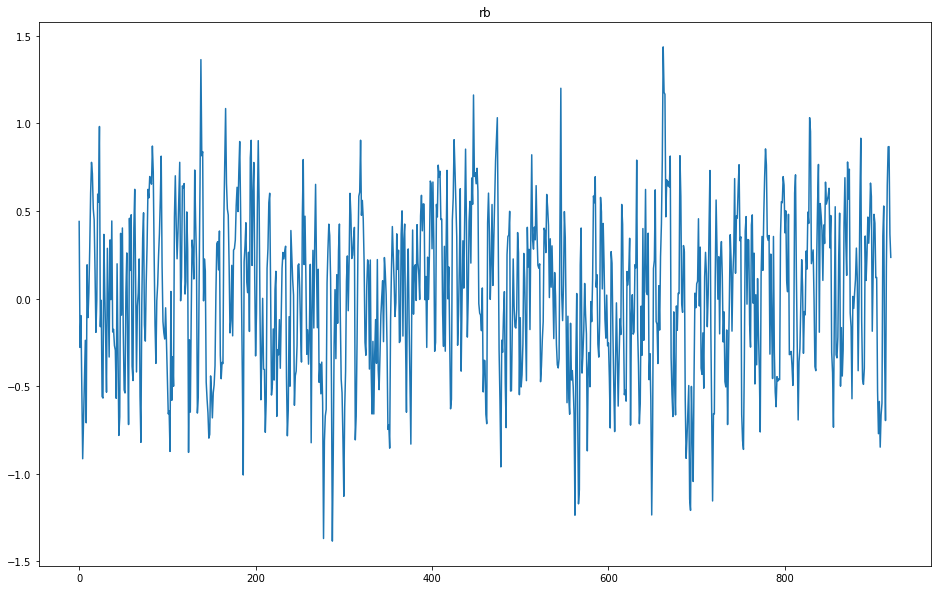

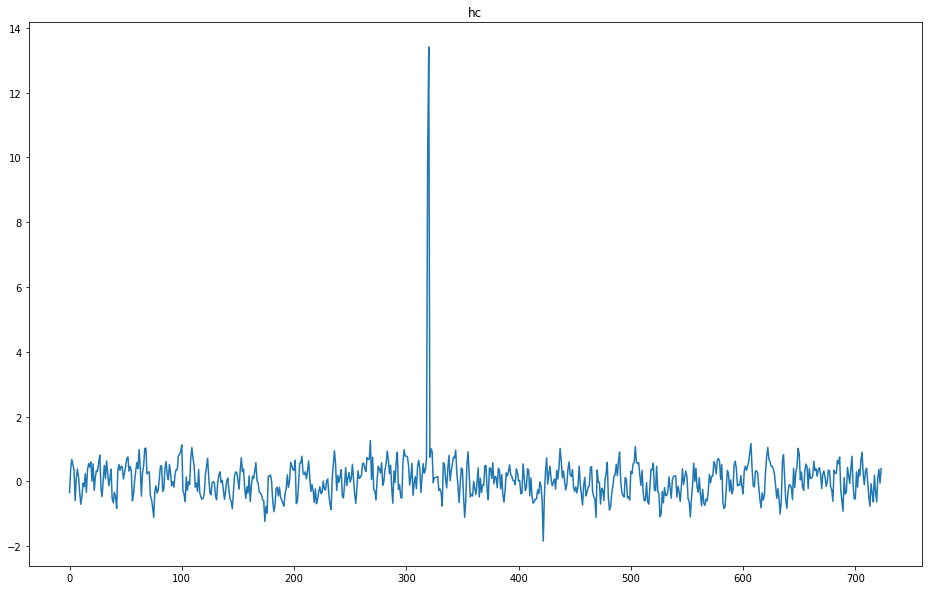

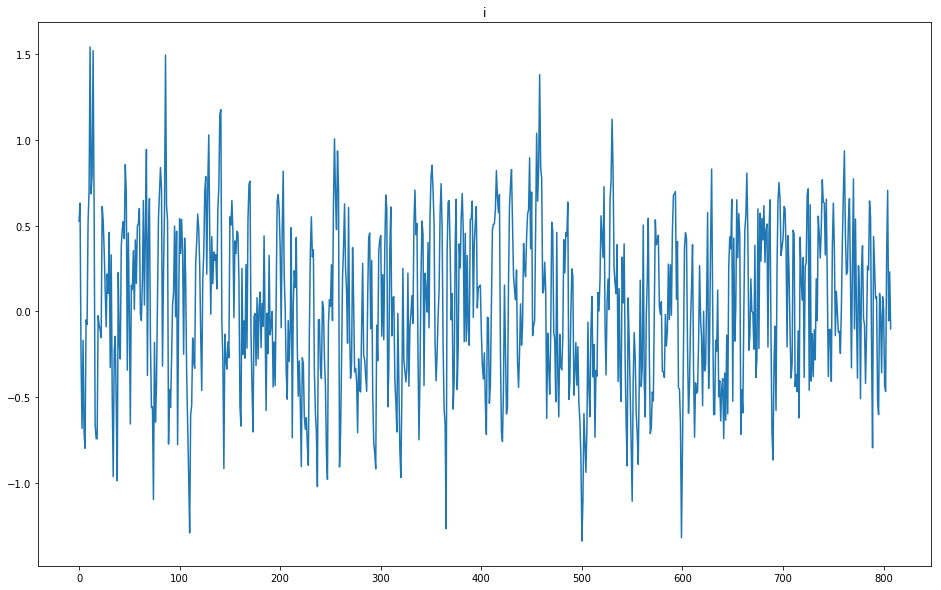

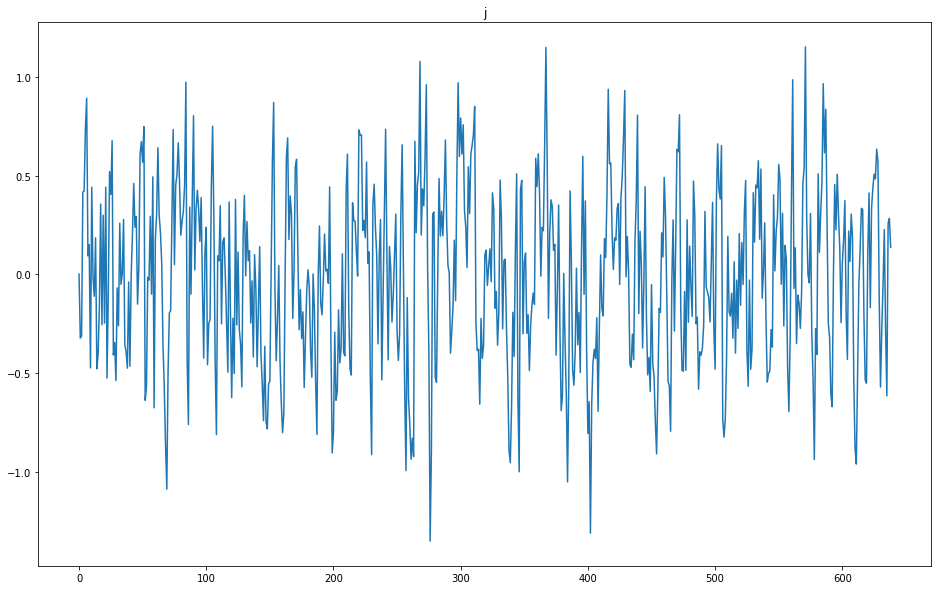

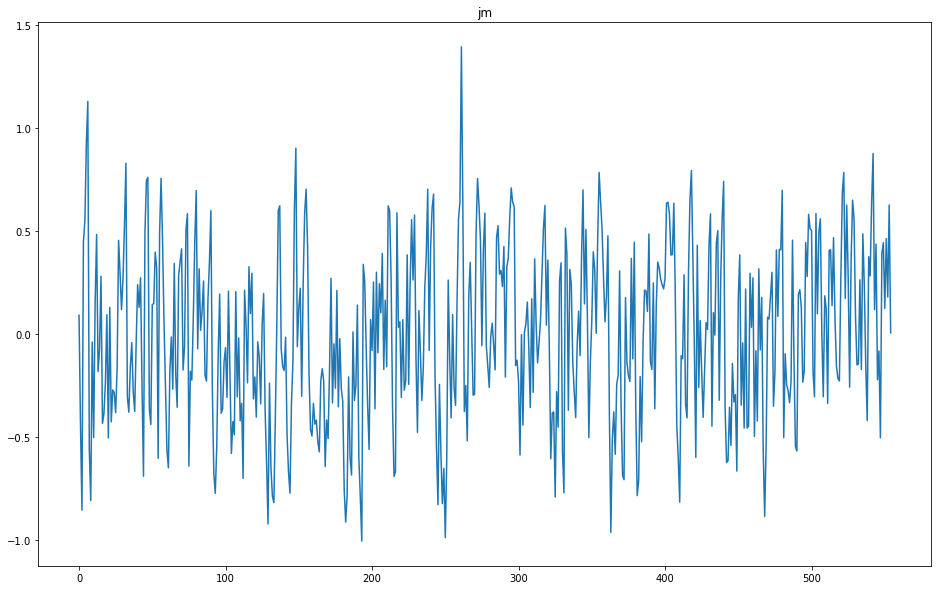

In [12]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "price.osci."+str(period), period)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

- before the last signal, let's do some analysis of skewness and kurtosis

In [13]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.6, 1, 0.02)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)

(100, 2)

training
testing
rb train sharpe  0.8491979861695438 test sharpe  1.491293571379304
j train sharpe  1.2077817519659253 test sharpe  0.055395091458323845
jm train sharpe  0.45360620738046725 test sharpe  -1.3292203675780243
train sharpe:  1.203068077473663 test sharpe:  0.2829734600639969
Wall time: 20min 22s


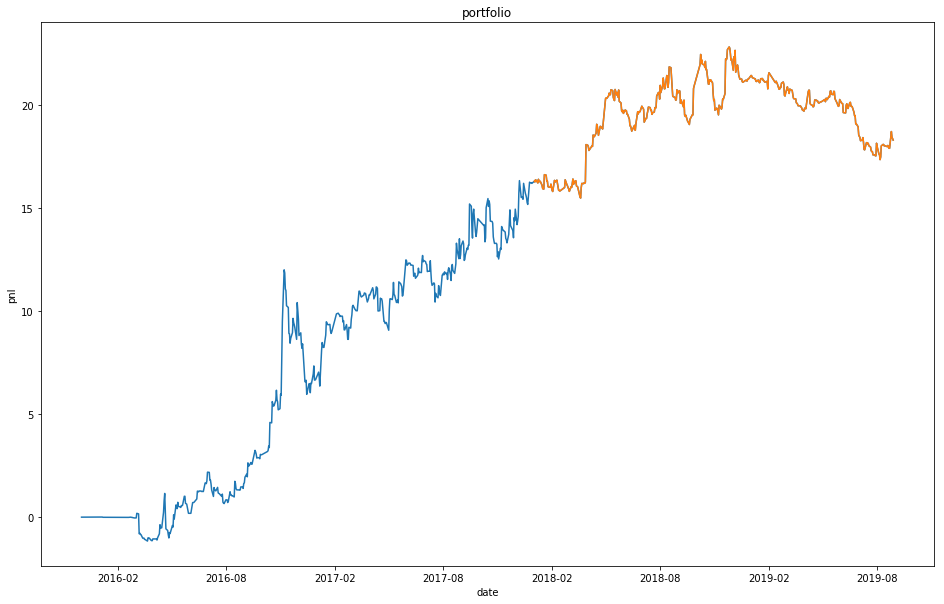

In [17]:
%%time
signal_stat = get_list_signal_stat("price.osci.4096", thre_mat, product_list, all_dates, reverse=1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=2, min_num=20)

# training
# testing
# rb train sharpe  0.8491979861695438 test sharpe  1.491293571379304
# j train sharpe  1.2077817519659253 test sharpe  0.055395091458323845
# jm train sharpe  0.45360620738046725 test sharpe  -1.3292203675780243
# train sharpe:  1.203068077473663 test sharpe:  0.2829734600639969
# Wall time: 20min 22s



rb train sharpe  0.8491979861695438 test sharpe  1.491293571379304
j train sharpe  1.2077817519659253 test sharpe  0.055395091458323845
jm train sharpe  0.45360620738046725 test sharpe  -1.3292203675780243
train sharpe:  1.203068077473663 test sharpe:  0.2829734600639969
Wall time: 173 ms


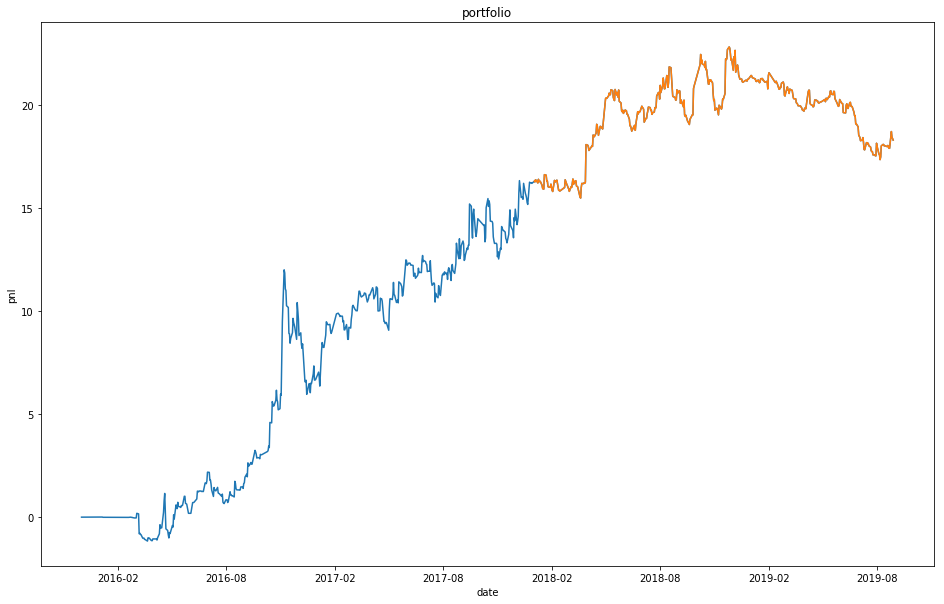

In [108]:
%%time
signal_stat = get_list_signal_result("price.osci.4096", product_list, all_dates, reverse=1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=2, min_num=20)


In [18]:
from scipy.stats import kurtosis
from scipy.stats import skew

In [20]:
def get_signal_moment(signal, all_dates, product_list, period):
    for product in product_list:
        all_signal = get_all_signal(np.array(all_dates), product, signal+"."+str(period), period)
        print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))

In [22]:
%%time
get_signal_moment("dbook", all_dates, product_list, 4096)
# rb kurtosis= 3.2639064084779887  skew= 0.13988608509070488
# hc kurtosis= 4.029980033761696  skew= -0.4992044280143049
# i kurtosis= 3.053906485844924  skew= 0.08952298897688339
# j kurtosis= 3.4343138665162876  skew= -0.08372314354606099
# jm kurtosis= 3.3708305826232943  skew= 0.043998182584974094
## Wall time: 1min 21s

rb kurtosis= 3.2639064084779887  skew= 0.13988608509070488
hc kurtosis= 4.029980033761696  skew= -0.4992044280143049
i kurtosis= 3.053906485844924  skew= 0.08952298897688339
j kurtosis= 3.4343138665162876  skew= -0.08372314354606099
jm kurtosis= 3.3708305826232943  skew= 0.043998182584974094
Wall time: 1min 21s


In [23]:
%%time
get_signal_moment("trade.imb", all_dates, product_list, 4096)
# rb kurtosis= 3.3295813756195183  skew= -0.0517987556898723
# hc kurtosis= 24.92067673312901  skew= -2.6805294967844078
# i kurtosis= 3.5720239643243303  skew= 0.12430016641538827
# j kurtosis= 4.071349381504733  skew= 0.05370422539584724
# jm kurtosis= 4.206116941917623  skew= 0.24349558050956707
# Wall time: 1min 44s


rb kurtosis= 3.3295813756195183  skew= -0.0517987556898723
hc kurtosis= 24.92067673312901  skew= -2.6805294967844078
i kurtosis= 3.5720239643243303  skew= 0.12430016641538827
j kurtosis= 4.071349381504733  skew= 0.05370422539584724
jm kurtosis= 4.206116941917623  skew= 0.24349558050956707
Wall time: 1min 44s


In [24]:
%%time
get_signal_moment("range.pos", all_dates, product_list, 4096)

# rb kurtosis= 2.4184513250184936  skew= -0.052501267081691776
# hc kurtosis= 2.4206708552018563  skew= 0.018455500839901336
# i kurtosis= 2.3245337505034556  skew= -0.0741481065438106
# j kurtosis= 2.5113787662546567  skew= -0.11441356512299831
# jm kurtosis= 2.401870476844649  skew= -0.0353526430339216
# Wall time: 1min 43s

rb kurtosis= 2.4184513250184936  skew= -0.052501267081691776
hc kurtosis= 2.4206708552018563  skew= 0.018455500839901336
i kurtosis= 2.3245337505034556  skew= -0.0741481065438106
j kurtosis= 2.5113787662546567  skew= -0.11441356512299831
jm kurtosis= 2.401870476844649  skew= -0.0353526430339216
Wall time: 1min 43s


In [30]:
%%time
get_signal_moment("ma.dif.10", all_dates, product_list, 4096)
# rb kurtosis= 5.975013294229626  skew= 0.008699654033963028
# hc kurtosis= 5.644079050336477  skew= 0.17260167647262747
# i kurtosis= 5.18283571461787  skew= 0.1362201200418672
# j kurtosis= 5.448917468350876  skew= -0.405684478984888
# jm kurtosis= 5.3460571355279045  skew= -0.3114411735492757
# Wall time: 1min 20s


rb kurtosis= 5.975013294229626  skew= 0.008699654033963028
hc kurtosis= 5.644079050336477  skew= 0.17260167647262747
i kurtosis= 5.18283571461787  skew= 0.1362201200418672
j kurtosis= 5.448917468350876  skew= -0.405684478984888
jm kurtosis= 5.3460571355279045  skew= -0.3114411735492757
Wall time: 1min 20s


In [31]:
%%time
get_signal_moment("price.osci", all_dates, product_list, 4096)
# rb kurtosis= 2.5775800802697018  skew= -0.12001435286203435
# hc kurtosis= 161.0111066529123  skew= 9.988507000823898
# i kurtosis= 2.567446140816511  skew= -0.035632147210554695
# j kurtosis= 2.558999573917937  skew= -0.05166469612734653
# jm kurtosis= 2.398882321387719  skew= 0.04790688072981409
# Wall time: 1min 28s


rb kurtosis= 2.5775800802697018  skew= -0.12001435286203435
hc kurtosis= 161.0111066529123  skew= 9.988507000823898
i kurtosis= 2.567446140816511  skew= -0.035632147210554695
j kurtosis= 2.558999573917937  skew= -0.05166469612734653
jm kurtosis= 2.398882321387719  skew= 0.04790688072981409
Wall time: 1min 28s


In [32]:
%%time
get_signal_moment("nr", all_dates, product_list, 4096)

# rb kurtosis= 3.4083092266976815  skew= 0.1642333600413905
# hc kurtosis= 3.91523474216243  skew= 0.19163584426556832
# i kurtosis= 3.7631836090459285  skew= -0.04916067441085127
# j kurtosis= 4.72195740585039  skew= 0.3154164469614875
# jm kurtosis= 4.178658277271627  skew= 0.40211610590272595

rb kurtosis= 3.4083092266976815  skew= 0.1642333600413905
hc kurtosis= 3.91523474216243  skew= 0.19163584426556832
i kurtosis= 3.7631836090459285  skew= -0.04916067441085127
j kurtosis= 4.72195740585039  skew= 0.3154164469614875
jm kurtosis= 4.178658277271627  skew= 0.40211610590272595
Wall time: 1min 45s


In [33]:
class foctor_kdj_k_period(factor_template):
    factor_name = "kdj.k.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5),
                   adjust=True).values
    

d:/intern/tmp pkl/jm/kdj.k.1024
d:/intern/tmp pkl/jm/kdj.k.2048
d:/intern/tmp pkl/jm/kdj.k.4096


In [34]:
x11 = foctor_kdj_k_period()
for product in product_list:
    create_signal_path(x11, product, HEAD_PATH)

d:/intern/tmp pkl/rb/kdj.k.1024
d:/intern/tmp pkl/rb/kdj.k.2048
d:/intern/tmp pkl/rb/kdj.k.4096
d:/intern/tmp pkl/hc/kdj.k.1024
d:/intern/tmp pkl/hc/kdj.k.2048
d:/intern/tmp pkl/hc/kdj.k.4096
d:/intern/tmp pkl/i/kdj.k.1024
d:/intern/tmp pkl/i/kdj.k.2048
d:/intern/tmp pkl/i/kdj.k.4096
d:/intern/tmp pkl/j/kdj.k.1024
d:/intern/tmp pkl/j/kdj.k.2048
d:/intern/tmp pkl/j/kdj.k.4096
d:/intern/tmp pkl/jm/kdj.k.1024
d:/intern/tmp pkl/jm/kdj.k.2048
d:/intern/tmp pkl/jm/kdj.k.4096


In [35]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x11, product=product, HEAD_PATH=HEAD_PATH)
;

Wall time: 10min 8s


rb kurtosis= 1.9167431999713611  skew= -0.08726420713997964
hc kurtosis= 1.769973339656085  skew= -0.020114762176448548
i kurtosis= 1.9082655267301265  skew= -0.062191404922021035
j kurtosis= 1.9120566348001473  skew= -0.018335353234932402
jm kurtosis= 1.8827243361159223  skew= 0.03430012345308844


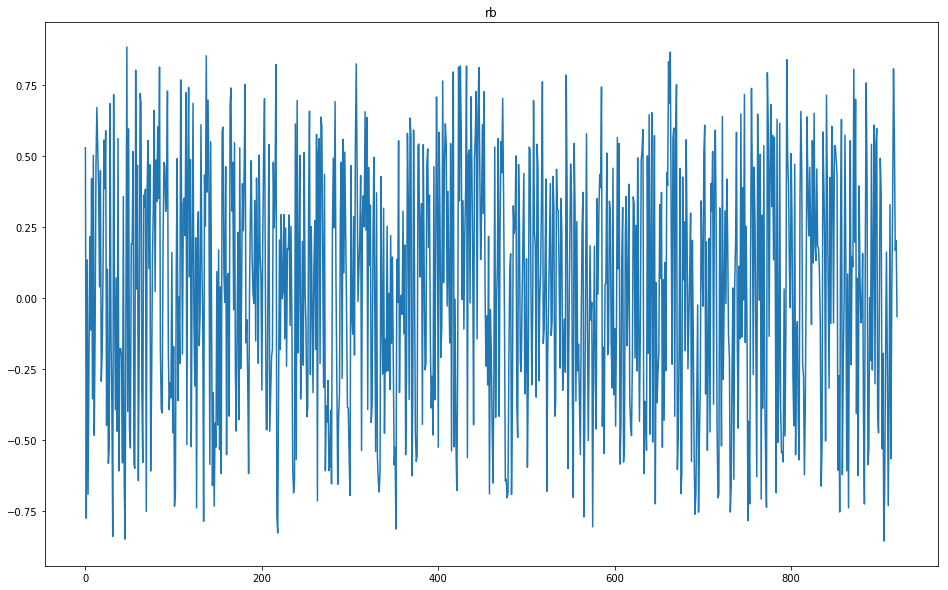

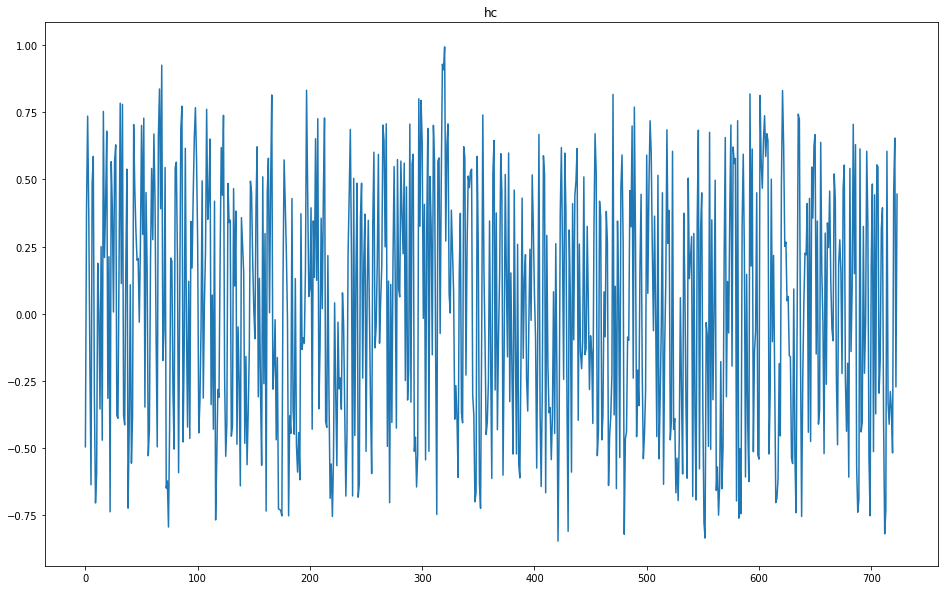

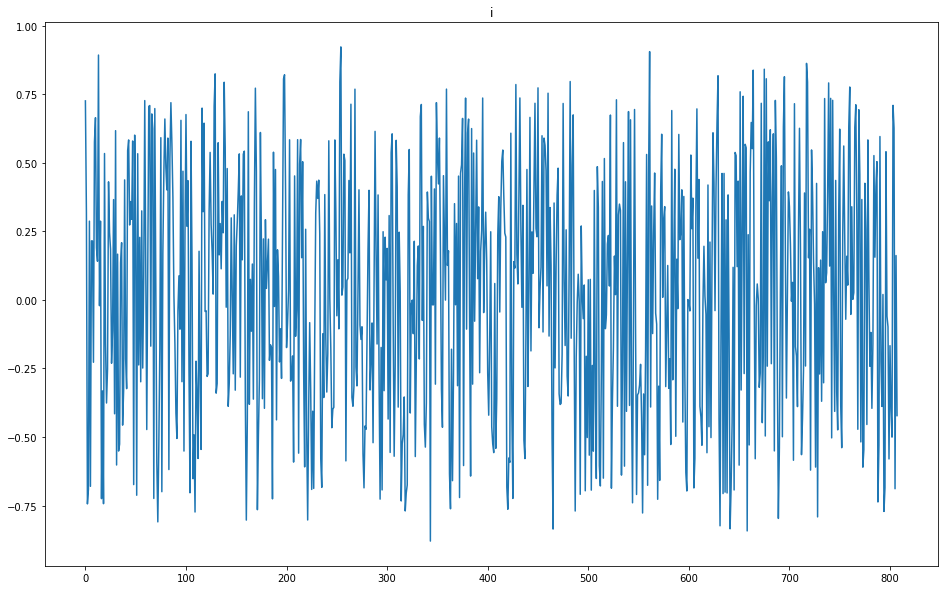

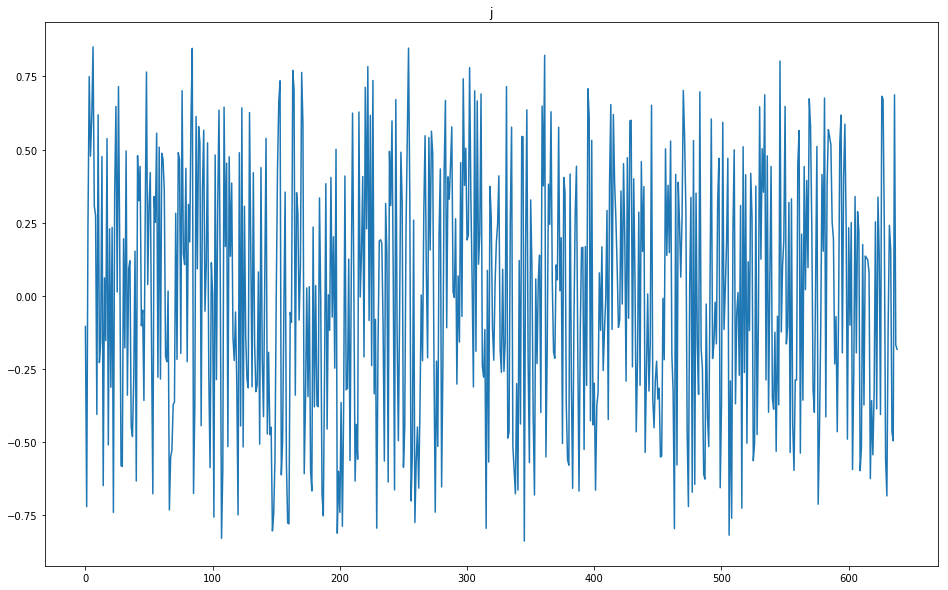

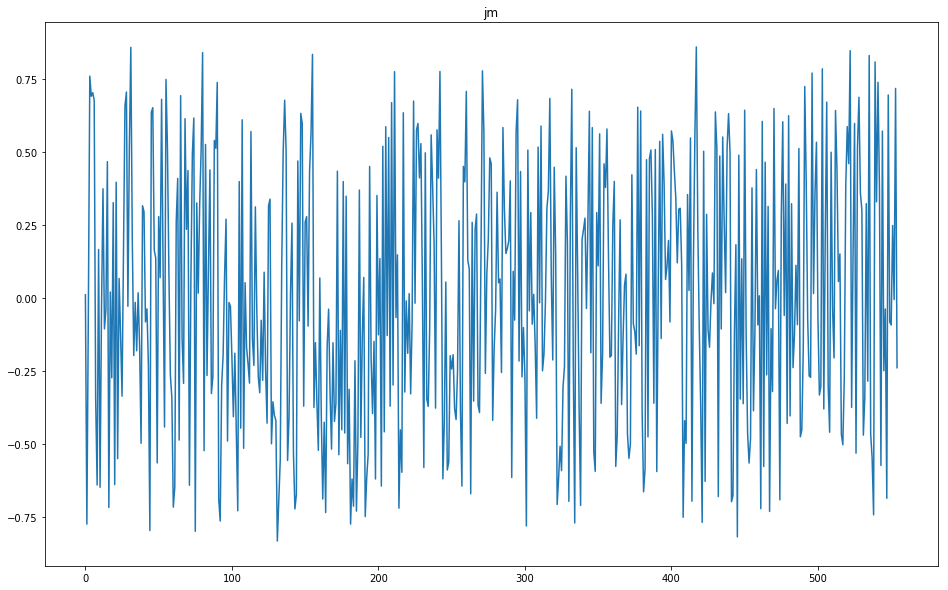

In [36]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "kdj.k."+str(period), period)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)
    print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))
# rb kurtosis= 1.9167431999713611  skew= -0.08726420713997964
# hc kurtosis= 1.769973339656085  skew= -0.020114762176448548
# i kurtosis= 1.9082655267301265  skew= -0.062191404922021035
# j kurtosis= 1.9120566348001473  skew= -0.018335353234932402
# jm kurtosis= 1.8827243361159223  skew= 0.03430012345308844



- we know that standard normal distribution is 3, so 3.29 is a little bit higher but still close to normal distribution
- as we see above, range.pos.signal and dbook.signal are good signals, they have kurtosis of slightly above 3
- open.int.ret.signal and nr.signal are not good signals, and they have kurtosis above 8
- nr.vanish.signal is better than nr.signal, and it has kurtosis much lower
- so when we want to improve our signals, we can focus on how to decrease the kurtosis


- kurtosis is used to measure fatness and thiness of the shape of the density distribution
- financial has fat tails, which may lead to large kurtosis value
- so we can use vanish techniques to reduce it 

In [90]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.5, 1, 0.025)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)

(100, 2)

In [91]:
%%time
signal_stat = get_list_signal_stat("kdj.k.4096", thre_mat, product_list, all_dates, reverse=-1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=2, min_num=20)
# training
# testing
# Wall time: 20min 13s


training
testing
Wall time: 20min 13s


In [ ]:
%%time
signal_stat = get_list_signal_stat("kdj.k.4096", thre_mat, product_list, all_dates, reverse=1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=2, min_num=20)
# training
# testing
# Wall time: 20min 13s

rb train sharpe  0.3179005488576118 test sharpe  0.49705533189622614
i train sharpe  0.49554894001046496 test sharpe  -0.7522932586362318
jm train sharpe  0.8361904301920405 test sharpe  0.0848399298467568
train sharpe:  0.8743650669532274 test sharpe:  0.08872322323157762
Wall time: 175 ms


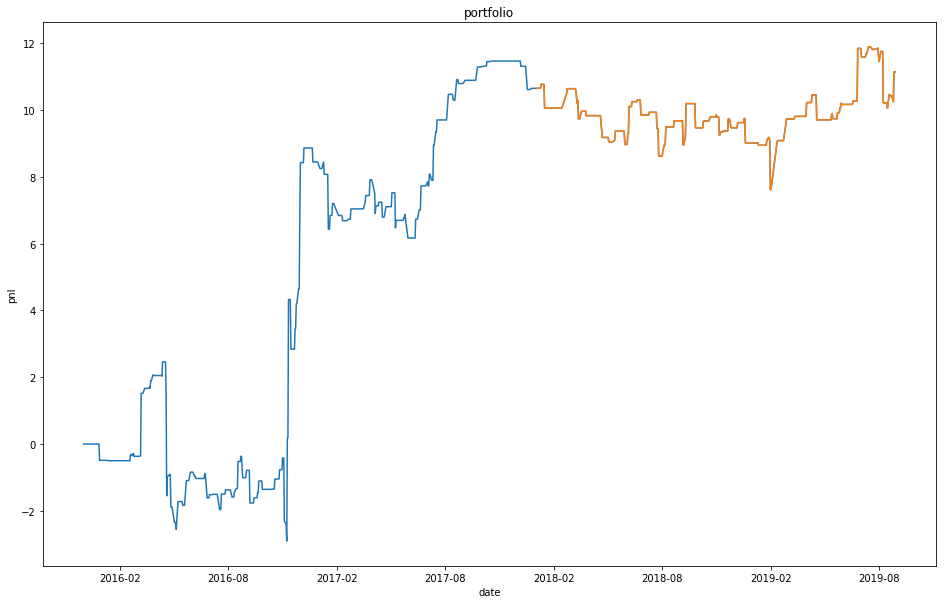

In [94]:
%%time
signal_stat = get_list_signal_result("kdj.k.4096", product_list, all_dates, reverse=-1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=3, min_num=20)

rb train sharpe  1.314198606191971 test sharpe  -0.03556129860434976
hc train sharpe  0.57848294599808 test sharpe  -2.4984655581485073
j train sharpe  0.6634180182074944 test sharpe  0.17277898985538417
jm train sharpe  0.7254553281301052 test sharpe  -0.6974698327805092
train sharpe:  1.452874243616417 test sharpe:  -0.6455712128678145
Wall time: 176 ms


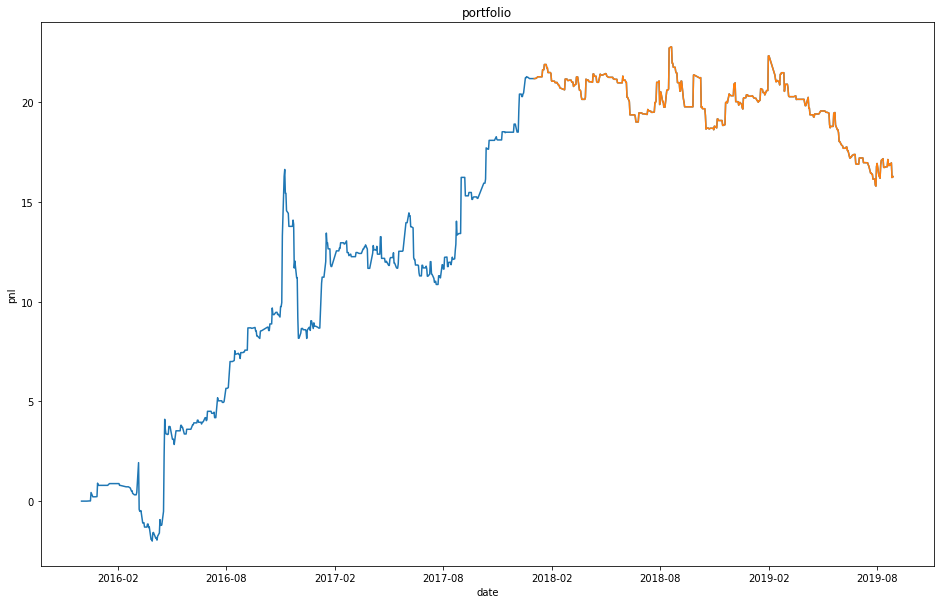

In [101]:
%%time
signal_stat = get_list_signal_result("kdj.k.4096", product_list, all_dates, reverse=1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=3, min_num=20)

In [39]:
class foctor_kdj_j_period(factor_template):
    factor_name = "kdj.j.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return ewma(ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5),
                        adjust=True), round(period/5), adjust=True).values
    


In [40]:
x12 = foctor_kdj_j_period()
for product in product_list:
    create_signal_path(x12, product, HEAD_PATH)

d:/intern/tmp pkl/rb/kdj.j.1024
d:/intern/tmp pkl/rb/kdj.j.2048
d:/intern/tmp pkl/rb/kdj.j.4096
d:/intern/tmp pkl/hc/kdj.j.1024
d:/intern/tmp pkl/hc/kdj.j.2048
d:/intern/tmp pkl/hc/kdj.j.4096
d:/intern/tmp pkl/i/kdj.j.1024
d:/intern/tmp pkl/i/kdj.j.2048
d:/intern/tmp pkl/i/kdj.j.4096
d:/intern/tmp pkl/j/kdj.j.1024
d:/intern/tmp pkl/j/kdj.j.2048
d:/intern/tmp pkl/j/kdj.j.4096
d:/intern/tmp pkl/jm/kdj.j.1024
d:/intern/tmp pkl/jm/kdj.j.2048
d:/intern/tmp pkl/jm/kdj.j.4096


In [41]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x12, product=product, HEAD_PATH=HEAD_PATH)
;
# Wall time: 6min 37s

Wall time: 6min 37s


rb kurtosis= 2.0320613476981717  skew= -0.06074485121971566
hc kurtosis= 1.9621333268608645  skew= -0.051279062622282955
i kurtosis= 2.118568770639969  skew= -0.0918249282999728
j kurtosis= 2.0742280155841635  skew= -0.08541220648515659
jm kurtosis= 2.0242274171440786  skew= -0.041576092549169115
Wall time: 1min 21s


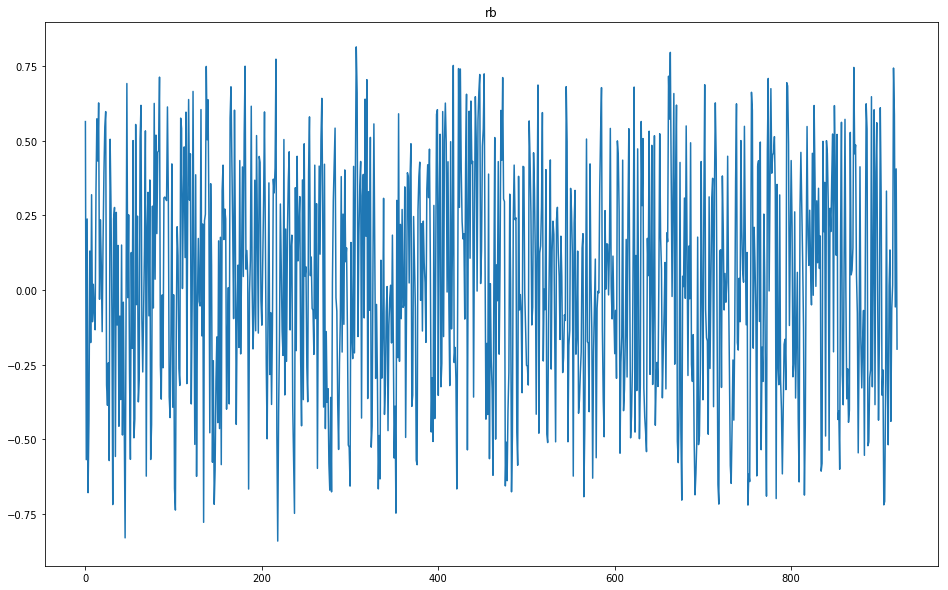

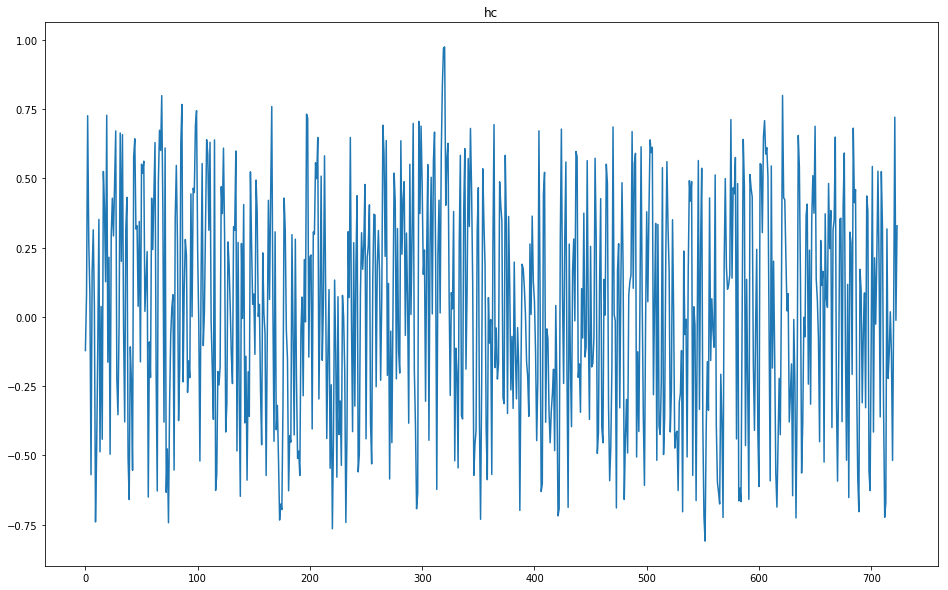

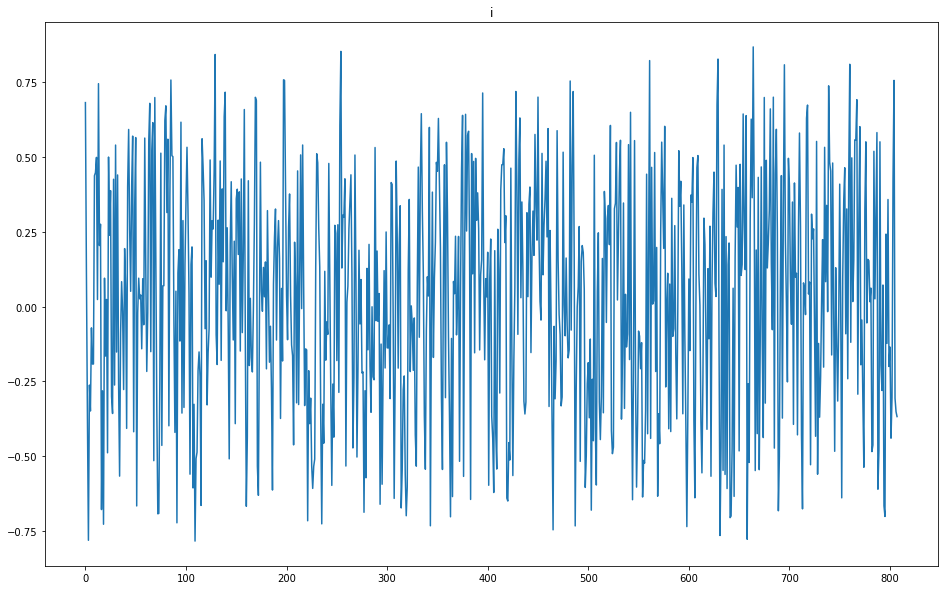

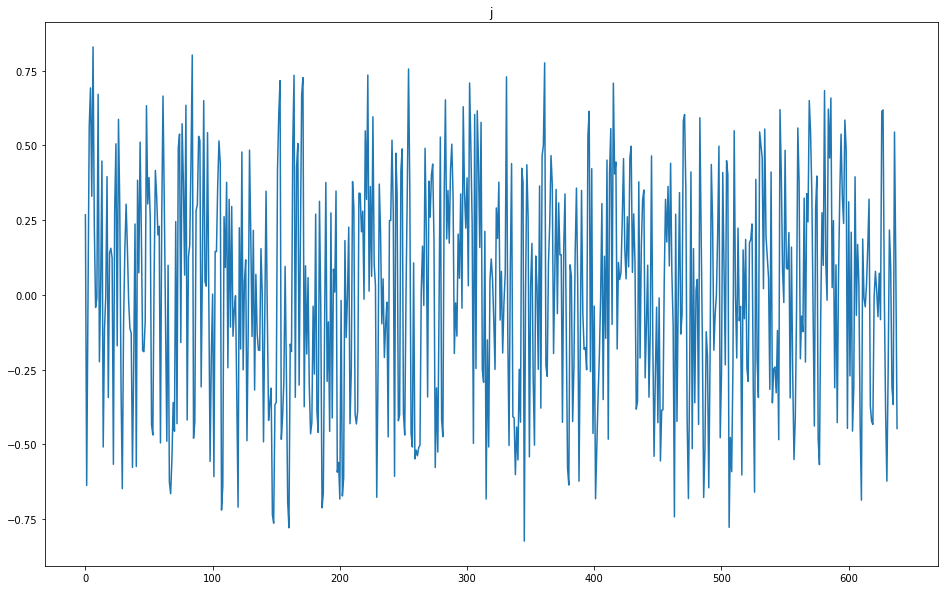

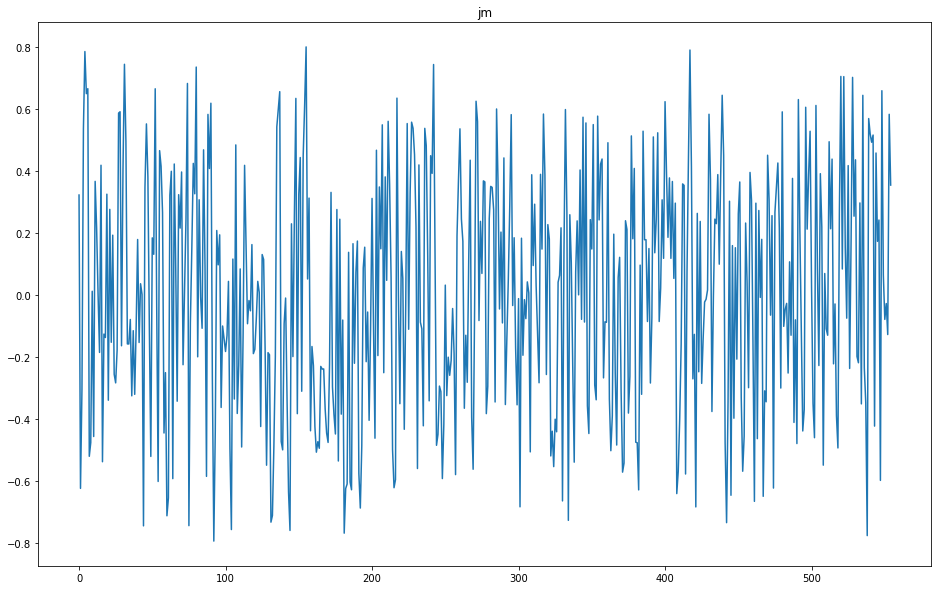

In [43]:
%%time
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "kdj.j."+str(period), period)
    i = i+1;
    plt.figure(i, figsize=(16, 10));
    plt.title(product);
    plt.plot(all_signal);
    print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal));

# rb kurtosis= 2.0320613476981717  skew= -0.06074485121971566
# hc kurtosis= 1.9621333268608645  skew= -0.051279062622282955
# i kurtosis= 2.118568770639969  skew= -0.0918249282999728
# j kurtosis= 2.0742280155841635  skew= -0.08541220648515659
# jm kurtosis= 2.0242274171440786  skew= -0.041576092549169115
# Wall time: 1min 21s



In [92]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.5, 1, 0.025)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)

(100, 2)

In [93]:
%%time
signal_stat = get_list_signal_stat("kdj.j.4096", thre_mat, product_list, all_dates, reverse=-1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=2, min_num=20)

# training
# testing
# Wall time: 14min 24s


training
testing
Wall time: 14min 24s


In [ ]:
%%time
signal_stat = get_list_signal_stat("kdj.j.4096", thre_mat, product_list, all_dates, reverse=1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=2, min_num=20)

rb train sharpe  0.2514736541152008 test sharpe  0.1467243592877959
hc train sharpe  0.4536532402108562 test sharpe  -0.12262569677877914
i train sharpe  0.5434378460530886 test sharpe  0.14059179721566548
jm train sharpe  0.23630186747050252 test sharpe  1.1449076601239385
train sharpe:  0.6364765187380289 test sharpe:  0.5663196440115988


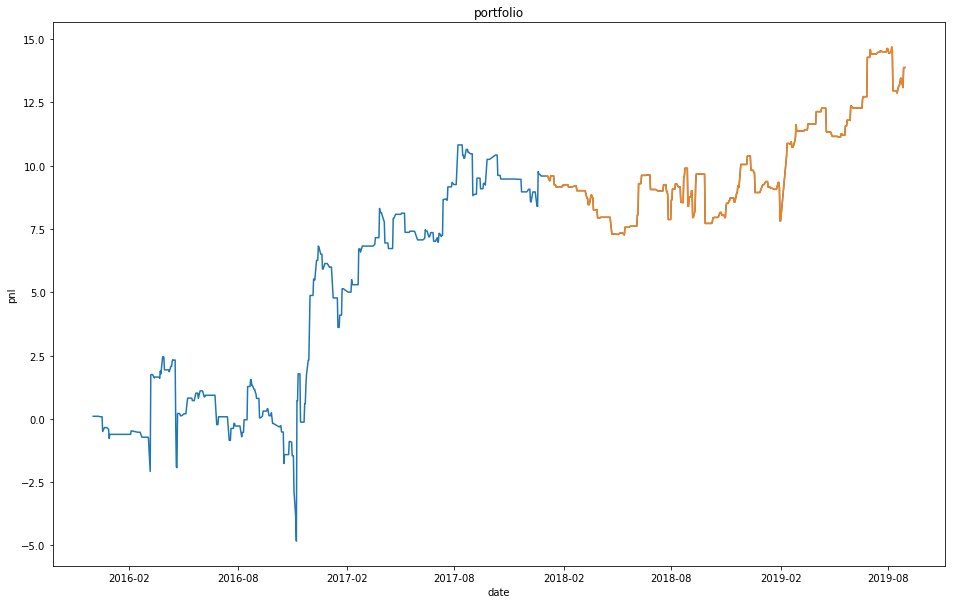

In [105]:
signal_stat = get_list_signal_result("kdj.j.4096", product_list, all_dates, reverse=-1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=1, min_num=20)


rb train sharpe  1.0728381621153533 test sharpe  0.09139707858285061
hc train sharpe  0.7391980032253145 test sharpe  -2.6049259545341332
j train sharpe  0.5622461832533877 test sharpe  0.16876365615748143
jm train sharpe  0.3154350209505611 test sharpe  -0.6507918446015779
train sharpe:  1.0973371512156407 test sharpe:  -0.6772853231920699


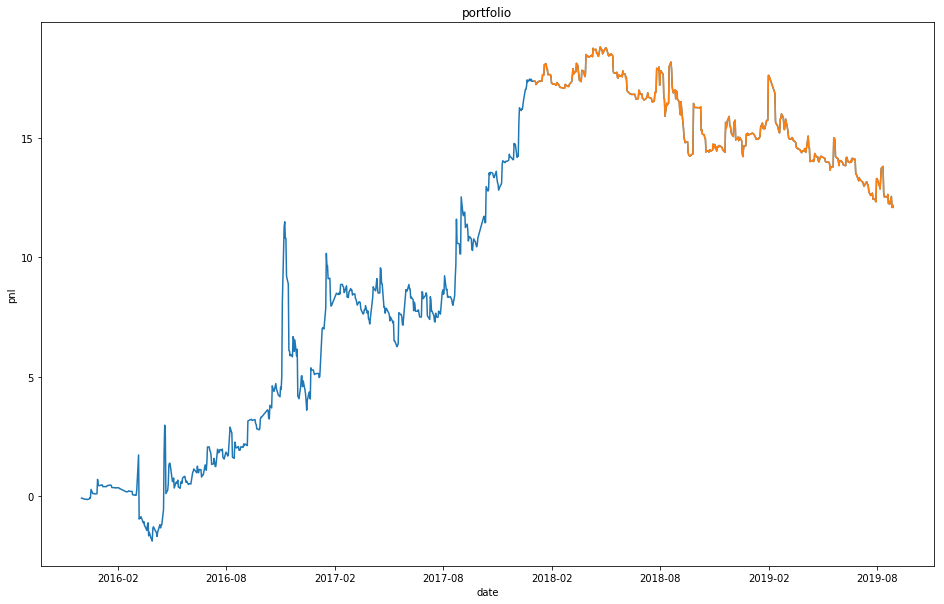

In [102]:
signal_stat = get_list_signal_result("kdj.j.4096", product_list, all_dates, reverse=1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=2, min_num=20)


rb train sharpe  0.2514736541152008 test sharpe  0.1467243592877959
hc train sharpe  0.4536532402108562 test sharpe  -0.12262569677877914
i train sharpe  0.5434378460530886 test sharpe  0.14059179721566548
jm train sharpe  0.23630186747050252 test sharpe  1.1449076601239385
train sharpe:  0.6364765187380289 test sharpe:  0.5663196440115988


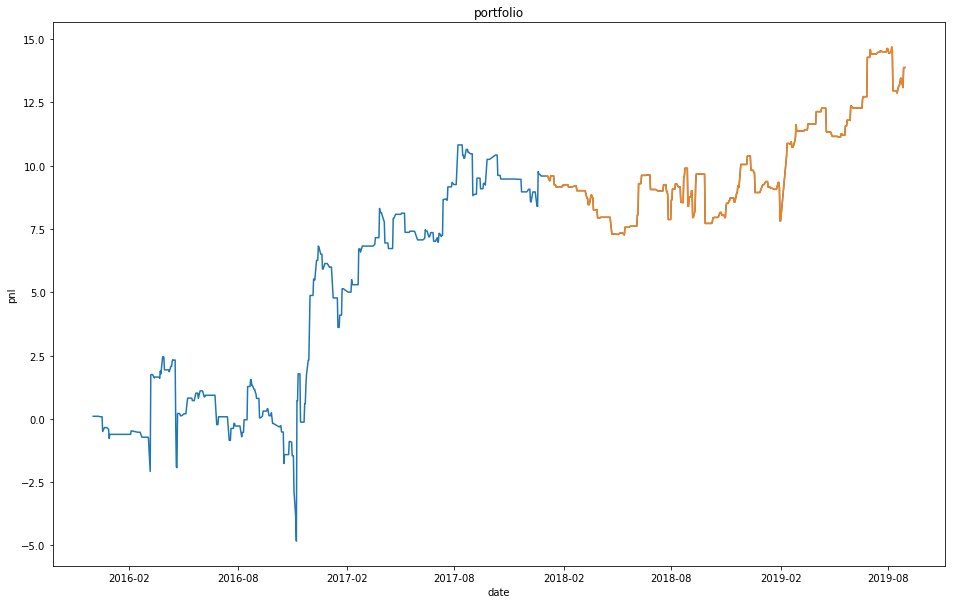

In [104]:
signal_stat = get_list_signal_result("kdj.j.4096", product_list, all_dates, reverse=-1, tranct=1.1e-4,
                                   tranct_ratio=True, min_pnl=1, min_num=20)